In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'American Airlines CNN Images Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## Prepare Test Data

In [8]:
nr_test_sets = ['HA','JBLU','AAL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    33.520000  30.035257  -7.208249  8558300.0     2.0
2019-01-23    32.720001  30.448294 -16.361556  7905500.0     2.0
2019-01-24    31.150000  30.556249 -34.324958  7085300.0     2.0
2019-01-25    31.500000  30.701441 -32.121223  8087300.0     2.0
2019-01-28    30.950001  30.739681 -41.184038  6956000.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    17.600000  17.005903  -4.149392  23132100.0     2.0
2019-01-23    17.370001  17.061918 -14.049519  19087600.0     2.0
2019-01-24    17.240000  17.089315 -19.421466  14999400.0     2.0
2019-01-25    18.120001  17.247882  -5.555506  23032100.0     2.0
2019-01-28    17.709999  17.318977 -26.363710  14531900.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date             

In [9]:
r_test_sets = ['HA','JBLU','AAL']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22    28.400000  29.290794 -81.099682  -783800.0     2.0
2020-01-23    29.120001  29.264518 -56.357370   281600.0     2.0
2020-01-24    29.840000  29.353054 -31.615125  1057900.0     2.0
2020-01-27    29.020000  29.301815 -59.793810   234600.0     2.0
2020-01-28    27.430000  29.013843 -89.999979  -739100.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    19.049999  18.785034 -29.629734  -5172900.0     2.0
2020-01-23    19.790001  18.939644 -15.920381   7229600.0     0.0
2020-01-24    21.070000  19.267391  -2.622949  23219300.0     2.0
2020-01-27    20.650000  19.480100 -18.060233  11950900.0     2.0
2020-01-28    20.040001  19.566239 -38.461529   3416600.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date             

## Train Hawaiian Holdings, Inc Stock Data

### Creating Training Data and Model

            previous_1d    EMA_12    willr_14     OBV_7  labels
Date                                                           
2000-01-21       2.0625  2.055042  -66.666667  186300.0     2.0
2000-01-24       2.0000  2.046574 -100.000000  173400.0     2.0
2000-01-25       1.9375  2.029793 -100.000000  105600.0     2.0
2000-01-26       1.9375  2.015594  -75.000000  105600.0     2.0
2000-01-27       2.0000  2.013195  -50.000000  121200.0     2.0


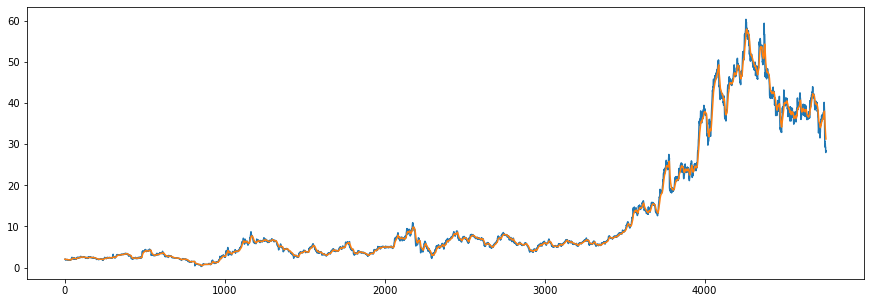

(4745, 64, 64, 1)

In [10]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/HA_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

In [11]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4745, 15, 1)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [13]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

In [14]:
from collections import Counter

Counter(y)

Counter({1.0: 216, 2.0: 4332, 0.0: 197})

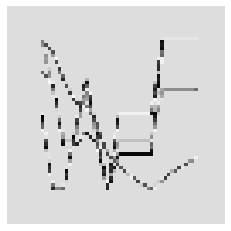

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['HA','JBLU','AAL']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'HawaiianModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'HawaiianModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 8.0084388185654, 1: 7.3140655105973025, 2: 0.36517556517556515}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/30 [>.............................] - ETA: 0s - loss: 0.2577 - accuracy: 0.6797 - mse: 5.5551 - weighted_accuracy: 0.4311 - weighted_mse: 5.7959WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 24ms/step - loss: 0.2424 - accuracy: 0.3646 - mse: 1.6310 - weighted_accuracy: 0.3228 - weighted_mse: 1.6466 - val_loss: 0.2424 - val_accuracy: 0.0453 - val_mse: 1.0050 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 1.0050
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2087 - accuracy: 0.1520 - mse: 1.2483 - weighted_accuracy: 0.3257 - weighted_mse: 1.1870 - val_loss: 0.2065 -

7/7 [==============================] - 0s 9ms/step - loss: 0.2030 - accuracy: 0.0594 - mse: 1.0052 - weighted_accuracy: 0.0594 - weighted_mse: 1.0052
Test loss: 0.20301643013954163
Test accuracy: 0.05936073139309883


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 7
actual predicted sells: 3
actual sells but predicted hold: 0
actual holds but predicted buy: 161
actual holds but predicted sell: 38
actual predicted holds: 0
Percentage buys correct: 5.617977528089888%
Percentage sells correct: 7.317073170731708%
Percentage holds correct: 0%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 42.3728813559322%
Percentage high sells correct: 56.09756097560975%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Price increase from previously bough

7/7 [==============================] - 0s 2ms/step - loss: 0.2033 - accuracy: 0.0594 - mse: 0.9922 - weighted_accuracy: 0.0594 - weighted_mse: 0.9922
Test loss: 0.20333890616893768
Test accuracy: 0.05936073139309883


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 10
actual predicted sells: 2
actual sells but predicted hold: 0
actual holds but predicted buy: 158
actual holds but predicted sell: 38
actual predicted holds: 1
Percentage buys correct: 5.617977528089888%
Percentage sells correct: 5.0%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.45762711864407%
Percentage high sells correct: 57.5%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


Price increase from previously bought: 5.219092982421

7/7 [==============================] - 0s 3ms/step - loss: 0.2042 - accuracy: 0.0594 - mse: 1.0091 - weighted_accuracy: 0.0594 - weighted_mse: 1.0091
Test loss: 0.2041829377412796
Test accuracy: 0.05936073139309883


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 8
actual predicted sells: 4
actual sells but predicted hold: 0
actual holds but predicted buy: 158
actual holds but predicted sell: 40
actual predicted holds: 0
Percentage buys correct: 5.142857142857143%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 0%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 43.10344827586207%
Percentage high sells correct: 52.27272727272727%
Percentage mid holds correct: 0%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -2.025085723656

30/30 [==============================] - 0s 12ms/step - loss: 0.1904 - accuracy: 0.2563 - mse: 1.2281 - weighted_accuracy: 0.4612 - weighted_mse: 1.2017 - val_loss: 0.2009 - val_accuracy: 0.0748 - val_mse: 1.1021 - val_weighted_accuracy: 0.0748 - val_weighted_mse: 1.1021
Epoch 10/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1908 - accuracy: 0.2616 - mse: 1.2220 - weighted_accuracy: 0.4527 - weighted_mse: 1.2142 - val_loss: 0.2007 - val_accuracy: 0.0727 - val_mse: 0.9946 - val_weighted_accuracy: 0.0727 - val_weighted_mse: 0.9946
Epoch 11/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1884 - accuracy: 0.2331 - mse: 1.2203 - weighted_accuracy: 0.4730 - weighted_mse: 1.1991 - val_loss: 0.2013 - val_accuracy: 0.0759 - val_mse: 1.0227 - val_weighted_accuracy: 0.0759 - val_weighted_mse: 1.0227
Epoch 12/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1898 - accuracy: 0.2318 - mse: 1.2432 - weighted_accuracy: 0.4392 - weighted_mse: 1.

7/7 [==============================] - 0s 4ms/step - loss: 0.2007 - accuracy: 0.0776 - mse: 1.1829 - weighted_accuracy: 0.0776 - weighted_mse: 1.1829
Test loss: 0.2007032036781311
Test accuracy: 0.077625572681427


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 138
actual holds but predicted sell: 61
actual predicted holds: 0
Percentage buys correct: 6.622516556291391%
Percentage sells correct: 10.294117647058824%
Percentage holds correct: 0%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 46.0%
Percentage high sells correct: 54.411764705882355%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Price increase from previously bought: -78.738431

7/7 [==============================] - 0s 3ms/step - loss: 0.2012 - accuracy: 0.0776 - mse: 1.1696 - weighted_accuracy: 0.0776 - weighted_mse: 1.1696
Test loss: 0.20118890702724457
Test accuracy: 0.077625572681427


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 121
actual holds but predicted sell: 76
actual predicted holds: 0
Percentage buys correct: 7.352941176470588%
Percentage sells correct: 8.433734939759036%
Percentage holds correct: 0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.370370370370374%
Percentage high sells correct: 55.42168674698795%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


Price increase from previously bough

7/7 [==============================] - 0s 3ms/step - loss: 0.2013 - accuracy: 0.0685 - mse: 1.1943 - weighted_accuracy: 0.0685 - weighted_mse: 1.1943
Test loss: 0.20130617916584015
Test accuracy: 0.06849315017461777


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 122
actual holds but predicted sell: 76
actual predicted holds: 0
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 9.30232558139535%
Percentage holds correct: 0%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 46.21212121212121%
Percentage high sells correct: 48.83720930232558%
Percentage mid holds correct: 0%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -2.02508572365

30/30 [==============================] - 0s 16ms/step - loss: 0.1845 - accuracy: 0.1992 - mse: 1.2684 - weighted_accuracy: 0.4912 - weighted_mse: 1.2379 - val_loss: 0.2002 - val_accuracy: 0.0727 - val_mse: 1.0879 - val_weighted_accuracy: 0.0727 - val_weighted_mse: 1.0879
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1803 - accuracy: 0.2123 - mse: 1.3052 - weighted_accuracy: 0.5233 - weighted_mse: 1.2636 - val_loss: 0.1995 - val_accuracy: 0.0738 - val_mse: 1.1009 - val_weighted_accuracy: 0.0738 - val_weighted_mse: 1.1009
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1831 - accuracy: 0.2094 - mse: 1.2641 - weighted_accuracy: 0.5054 - weighted_mse: 1.2210 - val_loss: 0.1990 - val_accuracy: 0.0717 - val_mse: 1.1774 - val_weighted_accuracy: 0.0717 - val_weighted_mse: 1.1774
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1823 - accuracy: 0.1791 - mse: 1.3351 - weighted_accuracy: 0.4800 - weighted_mse: 1.290

7/7 [==============================] - 0s 4ms/step - loss: 0.2066 - accuracy: 0.0913 - mse: 1.2338 - weighted_accuracy: 0.0913 - weighted_mse: 1.2338
Test loss: 0.20663759112358093
Test accuracy: 0.09132420271635056


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 140
actual holds but predicted sell: 56
actual predicted holds: 3
Percentage buys correct: 6.5359477124183005%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 46.71052631578947%
Percentage high sells correct: 58.73015873015873%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Price increase from previo

7/7 [==============================] - 0s 3ms/step - loss: 0.2059 - accuracy: 0.1005 - mse: 1.2102 - weighted_accuracy: 0.1005 - weighted_mse: 1.2102
Test loss: 0.20591512322425842
Test accuracy: 0.1004566177725792


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 128
actual holds but predicted sell: 64
actual predicted holds: 5
Percentage buys correct: 6.993006993006993%
Percentage sells correct: 9.859154929577464%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 49.29577464788732%
Percentage high sells correct: 59.15492957746479%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


Price increase from previous

7/7 [==============================] - 0s 3ms/step - loss: 0.2083 - accuracy: 0.1142 - mse: 1.2524 - weighted_accuracy: 0.1142 - weighted_mse: 1.2524
Test loss: 0.20829527080059052
Test accuracy: 0.11415524780750275


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 5
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 132
actual holds but predicted sell: 55
actual predicted holds: 11
Percentage buys correct: 4.861111111111111%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 91.66666666666667%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 45.45454545454545%
Percentage high sells correct: 50.79365079365079%
Percentage mid holds correct: 75.0%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bo

30/30 [==============================] - 1s 17ms/step - loss: 0.1664 - accuracy: 0.1815 - mse: 1.3924 - weighted_accuracy: 0.5711 - weighted_mse: 1.3321 - val_loss: 0.2005 - val_accuracy: 0.1475 - val_mse: 1.2460 - val_weighted_accuracy: 0.1475 - val_weighted_mse: 1.2460
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1611 - accuracy: 0.1810 - mse: 1.4165 - weighted_accuracy: 0.5816 - weighted_mse: 1.4048 - val_loss: 0.2020 - val_accuracy: 0.1212 - val_mse: 1.2536 - val_weighted_accuracy: 0.1212 - val_weighted_mse: 1.2536
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1653 - accuracy: 0.1920 - mse: 1.3983 - weighted_accuracy: 0.5894 - weighted_mse: 1.3545 - val_loss: 0.2032 - val_accuracy: 0.1264 - val_mse: 1.1671 - val_weighted_accuracy: 0.1264 - val_weighted_mse: 1.1671
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1628 - accuracy: 0.1836 - mse: 1.4468 - weighted_accuracy: 0.6012 - weighted_mse: 1.398

7/7 [==============================] - 0s 3ms/step - loss: 0.2041 - accuracy: 0.1416 - mse: 1.3718 - weighted_accuracy: 0.1416 - weighted_mse: 1.3718
Test loss: 0.20411206781864166
Test accuracy: 0.14155250787734985


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 122
actual holds but predicted sell: 62
actual predicted holds: 15
Percentage buys correct: 6.7669172932330826%
Percentage sells correct: 10.0%
Percentage holds correct: 93.75%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 45.45454545454545%
Percentage high sells correct: 51.42857142857143%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Price increase from previously bought: 

7/7 [==============================] - 0s 3ms/step - loss: 0.2015 - accuracy: 0.2374 - mse: 1.3387 - weighted_accuracy: 0.2374 - weighted_mse: 1.3387
Test loss: 0.20151783525943756
Test accuracy: 0.23744292557239532


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 101
actual holds but predicted sell: 61
actual predicted holds: 35
Percentage buys correct: 8.108108108108109%
Percentage sells correct: 11.428571428571429%
Percentage holds correct: 92.10526315789474%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 49.09090909090909%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 86.84210526315789%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


P

7/7 [==============================] - 0s 3ms/step - loss: 0.2068 - accuracy: 0.1560 - mse: 1.3930 - weighted_accuracy: 0.1560 - weighted_mse: 1.3930
Test loss: 0.2067652940750122
Test accuracy: 0.15596330165863037


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 114
actual holds but predicted sell: 68
actual predicted holds: 21
Percentage buys correct: 6.504065040650406%
Percentage sells correct: 6.8493150684931505%
Percentage holds correct: 95.45454545454545%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 41.46341463414634%
Percentage high sells correct: 44.44444444444444%
Percentage mid holds correct: 81.81818181818181%


Capital: 100
Share price: $0.9786984277413346
Shares owned at the moment: 101
Cash capital at the moment: $0.8796253098200424


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.2064 - accuracy: 0.1735 - mse: 1.3965 - weighted_accuracy: 0.1735 - weighted_mse: 1.3965
Test loss: 0.2064262181520462
Test accuracy: 0.17351597547531128


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 5
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 109
actual holds but predicted sell: 65
actual predicted holds: 24
Percentage buys correct: 5.785123966942149%
Percentage sells correct: 9.58904109589041%
Percentage holds correct: 96.0%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 47.5%
Percentage high sells correct: 47.945205479452056%
Percentage mid holds correct: 92.0%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -2.0250857236561837%


Epoch 1/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1476 - accuracy: 0.2223 - mse: 1.5266 - weighted_accuracy: 0.6563 - weighted_mse: 1.5295 - val_loss: 0.2034 - val_accuracy: 0.1560 - val_mse: 1.4158 - val_weighted_accuracy: 0.1560 - val_weighted_mse: 1.4158
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1490 - accuracy: 0.2107 - mse: 1.5775 - weighted_accuracy: 0.6463 - weighted_mse: 1.5872 - val_loss: 0.1991 - val_accuracy: 0.1654 - val_mse: 1.4187 - val_weighted_accuracy: 0.1654 - val_weighted_mse: 1.4187
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1469 - accuracy: 0.2247 - mse: 1.5728 - weighted_accuracy: 0.6534 - weighted_mse: 1.5851 - val_loss: 0.2012 - val_accuracy: 0.1581 - val_mse: 1.3768 - val_weighted_accuracy: 0.1581 - val_weighted_mse: 1.3768
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1466 - accuracy: 0.2276 - mse: 1.5584 - weighted_accuracy: 0.6403 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1882 - accuracy: 0.3014 - mse: 1.6204 - weighted_accuracy: 0.3014 - weighted_mse: 1.6204
Test loss: 0.188249409198761
Test accuracy: 0.30136987566947937


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 99
actual holds but predicted sell: 45
actual predicted holds: 55
Percentage buys correct: 3.8461538461538463%
Percentage sells correct: 13.20754716981132%
Percentage holds correct: 88.70967741935483%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 41.74757281553398%
Percentage high sells correct: 56.60377358490566%
Percentage mid holds correct: 80.64516129032258%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Price

7/7 [==============================] - 0s 2ms/step - loss: 0.1834 - accuracy: 0.3562 - mse: 1.5782 - weighted_accuracy: 0.3562 - weighted_mse: 1.5782
Test loss: 0.18338549137115479
Test accuracy: 0.3561643958091736


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 83
actual holds but predicted sell: 49
actual predicted holds: 65
Percentage buys correct: 5.617977528089888%
Percentage sells correct: 13.793103448275861%
Percentage holds correct: 90.27777777777777%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 48.86363636363637%
Percentage high sells correct: 55.172413793103445%
Percentage mid holds correct: 86.11111111111111%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


Pri

7/7 [==============================] - 0s 3ms/step - loss: 0.1920 - accuracy: 0.3105 - mse: 1.6493 - weighted_accuracy: 0.3105 - weighted_mse: 1.6493
Test loss: 0.19199730455875397
Test accuracy: 0.310502290725708


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 5
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 87
actual holds but predicted sell: 54
actual predicted holds: 57
Percentage buys correct: 5.154639175257732%
Percentage sells correct: 9.836065573770492%
Percentage holds correct: 93.44262295081967%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 44.791666666666664%
Percentage high sells correct: 47.540983606557376%
Percentage mid holds correct: 88.52459016393442%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from p

30/30 [==============================] - 1s 17ms/step - loss: 0.1375 - accuracy: 0.3728 - mse: 1.7362 - weighted_accuracy: 0.6924 - weighted_mse: 1.8703 - val_loss: 0.1849 - val_accuracy: 0.3772 - val_mse: 1.6952 - val_weighted_accuracy: 0.3772 - val_weighted_mse: 1.6952
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1334 - accuracy: 0.3691 - mse: 1.8103 - weighted_accuracy: 0.7118 - weighted_mse: 1.9829 - val_loss: 0.1842 - val_accuracy: 0.3625 - val_mse: 1.5884 - val_weighted_accuracy: 0.3625 - val_weighted_mse: 1.5884
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1333 - accuracy: 0.3872 - mse: 1.8024 - weighted_accuracy: 0.7222 - weighted_mse: 1.9621 - val_loss: 0.1882 - val_accuracy: 0.3498 - val_mse: 1.6276 - val_weighted_accuracy: 0.3498 - val_weighted_mse: 1.6276
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1313 - accuracy: 0.3820 - mse: 1.8443 - weighted_accuracy: 0.7148 - weighted_mse: 2.027

7/7 [==============================] - 0s 2ms/step - loss: 0.1767 - accuracy: 0.4612 - mse: 1.8925 - weighted_accuracy: 0.4612 - weighted_mse: 1.8925
Test loss: 0.17672808468341827
Test accuracy: 0.4611872136592865


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 68
actual holds but predicted sell: 40
actual predicted holds: 91
Percentage buys correct: 4.225352112676056%
Percentage sells correct: 14.583333333333334%
Percentage holds correct: 91.0%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 42.857142857142854%
Percentage high sells correct: 58.333333333333336%
Percentage mid holds correct: 86.0%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -79.3

7/7 [==============================] - 0s 2ms/step - loss: 0.1684 - accuracy: 0.4840 - mse: 1.8231 - weighted_accuracy: 0.4840 - weighted_mse: 1.8231
Test loss: 0.1684078425168991
Test accuracy: 0.4840182662010193


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 57
actual holds but predicted sell: 42
actual predicted holds: 98
Percentage buys correct: 6.451612903225806%
Percentage sells correct: 8.51063829787234%
Percentage holds correct: 89.0909090909091%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 37.704918032786885%
Percentage high sells correct: 51.06382978723404%
Percentage mid holds correct: 84.54545454545455%


Capital: 100
Share price: $0.7848299580775777
Shares owned at the moment: 127
Cash capital at the moment: $0.052493461289031984


Price 

Share price: $0.7925371068881992
Shares owned at the moment: 97
Cash capital at the moment: $0.5566373819988684


Price increase from previously bought: -31.265595582003748%
Share price: $0.546243710776803
Shares owned at the moment: 0
Cash capital at the moment: $53.39656681749904


Share price: $0.5742503145397164
Shares owned at the moment: 92
Cash capital at the moment: $0.42025255026658215


Price increase from previously bought: -13.72091257284801%
Share price: $0.4968204402424814
Shares owned at the moment: 0
Cash capital at the moment: $46.00203748119352


Share price: $0.5709555031567095
Shares owned at the moment: 80
Cash capital at the moment: $0.1999870179622789


Price increase from previously bought: 23.03357338256977%
Share price: $0.7043987420925155
Shares owned at the moment: 0
Cash capital at the moment: $56.39691866210317


Share price: $0.7744150943870529
Shares owned at the moment: 72
Cash capital at the moment: $0.48569767754671744


Price increase from previously




RUNNING EPOCHS 120 - 140



Epoch 1/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1206 - accuracy: 0.4937 - mse: 2.0637 - weighted_accuracy: 0.7593 - weighted_mse: 2.4423 - val_loss: 0.1728 - val_accuracy: 0.4858 - val_mse: 1.7962 - val_weighted_accuracy: 0.4858 - val_weighted_mse: 1.7962
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1192 - accuracy: 0.5042 - mse: 2.0538 - weighted_accuracy: 0.7585 - weighted_mse: 2.4054 - val_loss: 0.1609 - val_accuracy: 0.5690 - val_mse: 1.8229 - val_weighted_accuracy: 0.5690 - val_weighted_mse: 1.8229
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1202 - accuracy: 0.5050 - mse: 2.0273 - weighted_accuracy: 0.7559 - weighted_mse: 2.3861 - val_loss: 0.1714 - val_accuracy: 0.5058 - val_mse: 1.9096 - val_weighted_accuracy: 0.5058 - val_weighted_mse: 1.9096
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1211 - accuracy: 0.5071 - mse: 2.1343 - weighte

7/7 [==============================] - 0s 2ms/step - loss: 0.1647 - accuracy: 0.5525 - mse: 2.0416 - weighted_accuracy: 0.5525 - weighted_mse: 2.0416
Test loss: 0.16466087102890015
Test accuracy: 0.5525113940238953


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 48
actual holds but predicted sell: 35
actual predicted holds: 116
Percentage buys correct: 4.0%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 88.54961832061069%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 44.89795918367347%
Percentage high sells correct: 57.89473684210526%
Percentage mid holds correct: 83.20610687022901%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bou

7/7 [==============================] - 0s 2ms/step - loss: 0.1543 - accuracy: 0.6164 - mse: 1.9451 - weighted_accuracy: 0.6164 - weighted_mse: 1.9451
Test loss: 0.15428908169269562
Test accuracy: 0.6164383292198181


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 37
actual holds but predicted sell: 32
actual predicted holds: 128
Percentage buys correct: 7.317073170731708%
Percentage sells correct: 10.81081081081081%
Percentage holds correct: 90.78014184397163%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 42.5%
Percentage high sells correct: 48.648648648648646%
Percentage mid holds correct: 85.81560283687944%


Capital: 100
Share price: $0.7848299580775777
Shares owned at the moment: 127
Cash capital at the moment: $0.052493461289031984


Price increase 

   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.591743     11.363636       9.523810      90.909091   
1       0.532110      9.090909       3.030303      91.596639   
2       0.568807      8.333333      12.820513      95.798319   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         54.545455           50.000000          82.442748     213.170622   
1         46.969697           53.125000          84.873950     -34.008141   
2         50.000000           46.153846          87.288136     -62.778542   

   buy_n_hold profit  
0          -2.642012  
1          19.481992  
2         -69.696371  


Recession


7/7 [==============================] - 0s 2ms/step - loss: 0.1718 - accuracy: 0.5434 - mse: 2.0559 - weighted_accuracy: 0.5434 - weighted_mse: 2.0559
Test loss: 0.1717744618654251
Test accuracy: 0.543379008769989


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted h

Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1067 - accuracy: 0.6099 - mse: 2.3895 - weighted_accuracy: 0.7812 - weighted_mse: 3.1253 - val_loss: 0.1516 - val_accuracy: 0.6238 - val_mse: 1.9711 - val_weighted_accuracy: 0.6238 - val_weighted_mse: 1.9711
Epoch 5/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1046 - accuracy: 0.6114 - mse: 2.3289 - weighted_accuracy: 0.8081 - weighted_mse: 3.1192 - val_loss: 0.1587 - val_accuracy: 0.5827 - val_mse: 2.0595 - val_weighted_accuracy: 0.5827 - val_weighted_mse: 2.0595
Epoch 6/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1086 - accuracy: 0.5909 - mse: 2.3188 - weighted_accuracy: 0.7838 - weighted_mse: 2.9716 - val_loss: 0.1468 - val_accuracy: 0.6291 - val_mse: 1.8898 - val_weighted_accuracy: 0.6291 - val_weighted_mse: 1.8898
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1081 - accuracy: 0.5904 - mse: 2.3143 - weighted_accuracy: 0.7900 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.1388 - accuracy: 0.7078 - mse: 2.2964 - weighted_accuracy: 0.7078 - weighted_mse: 2.2964
Test loss: 0.13876943290233612
Test accuracy: 0.7077625393867493


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 24
actual holds but predicted sell: 24
actual predicted holds: 151
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 90.41916167664671%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 46.15384615384615%
Percentage high sells correct: 61.53846153846154%
Percentage mid holds correct: 83.73493975903614%


Capital: 100
Share price: $0.8918936070916875
Shares owned at the moment: 111
Cash capital at the moment: $0.7275590892579515


Pri

7/7 [==============================] - 0s 2ms/step - loss: 0.1316 - accuracy: 0.7202 - mse: 2.2020 - weighted_accuracy: 0.7202 - weighted_mse: 2.2020
Test loss: 0.13162149488925934
Test accuracy: 0.7201834917068481


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 29
actual holds but predicted sell: 21
actual predicted holds: 153
Percentage buys correct: 3.3333333333333335%
Percentage sells correct: 12.5%
Percentage holds correct: 93.29268292682927%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 53.333333333333336%
Percentage high sells correct: 45.833333333333336%
Percentage mid holds correct: 85.88957055214723%


Capital: 100
Share price: $0.8831465409429533
Shares owned at the moment: 112
Cash capital at the moment: $0.8155782797788049


Price increase fr




RUNNING EPOCHS 160 - 180



Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0980 - accuracy: 0.6739 - mse: 2.5327 - weighted_accuracy: 0.8271 - weighted_mse: 3.4680 - val_loss: 0.1416 - val_accuracy: 0.6786 - val_mse: 2.2179 - val_weighted_accuracy: 0.6786 - val_weighted_mse: 2.2179
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0907 - accuracy: 0.6865 - mse: 2.7005 - weighted_accuracy: 0.8429 - weighted_mse: 3.7773 - val_loss: 0.1321 - val_accuracy: 0.7092 - val_mse: 2.2319 - val_weighted_accuracy: 0.7092 - val_weighted_mse: 2.2319
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0967 - accuracy: 0.6723 - mse: 2.6576 - weighted_accuracy: 0.8258 - weighted_mse: 3.6057 - val_loss: 0.1295 - val_accuracy: 0.7387 - val_mse: 2.3936 - val_weighted_accuracy: 0.7387 - val_weighted_mse: 2.3936
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0964 - accuracy: 0.6891 - mse: 2.7370 - weighte

7/7 [==============================] - 0s 2ms/step - loss: 0.1260 - accuracy: 0.7580 - mse: 2.8214 - weighted_accuracy: 0.7580 - weighted_mse: 2.8214
Test loss: 0.12603701651096344
Test accuracy: 0.7579908967018127


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 19
actual holds but predicted sell: 16
actual predicted holds: 164
Percentage buys correct: 5.0%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 90.10989010989012%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 40.0%
Percentage high sells correct: 64.70588235294117%
Percentage mid holds correct: 83.97790055248619%


Capital: 100
Share price: $0.8972620160283372
Shares owned at the moment: 111
Cash capital at the moment: $0.13002699046191424


Price increase from previously 



Share price: $0.5977551196499638
Shares owned at the moment: 126
Cash capital at the moment: $0.3325602255689688




Capital at the end of test period: $65.6125502525568
profit gained: -34.3874497474432%


Capital at the end of test period if Buy and Hold: $55.155916676290765
profit gained: -44.844083323709235%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.757991      5.000000       5.882353      90.109890   
1       0.785388      5.555556       9.090909      89.473684   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         40.000000           64.705882          83.977901     -80.887092   
1         41.176471           54.545455          84.736842     -34.387450   

   buy_n_hold profit  
0         -51.275942  
1         -44.844083  


Non-Recession


7/7 [==============================] - 0s 2ms/step - loss: 0.1120 - accuracy: 0.7661 - mse: 2.6682 - weighted_accuracy: 0.7661 - weighted_mse: 2.6682
Test loss: 0.1119894310

Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0846 - accuracy: 0.7500 - mse: 3.1278 - weighted_accuracy: 0.8602 - weighted_mse: 4.4822 - val_loss: 0.1301 - val_accuracy: 0.7323 - val_mse: 2.7882 - val_weighted_accuracy: 0.7323 - val_weighted_mse: 2.7882
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0817 - accuracy: 0.7513 - mse: 3.2119 - weighted_accuracy: 0.8695 - weighted_mse: 4.8146 - val_loss: 0.1303 - val_accuracy: 0.7323 - val_mse: 2.4474 - val_weighted_accuracy: 0.7323 - val_weighted_mse: 2.4474
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0797 - accuracy: 0.7534 - mse: 3.2313 - weighted_accuracy: 0.8695 - weighted_mse: 5.0032 - val_loss: 0.1307 - val_accuracy: 0.7292 - val_mse: 2.5887 - val_weighted_accuracy: 0.7292 - val_weighted_mse: 2.5887
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0800 - accuracy: 0.7619 - mse: 3.2564 - weighted_accuracy: 0.8649 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.1169 - accuracy: 0.8037 - mse: 3.3011 - weighted_accuracy: 0.8037 - weighted_mse: 3.3011
Test loss: 0.11685296148061752
Test accuracy: 0.8036529421806335


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 14
actual holds but predicted sell: 10
actual predicted holds: 175
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 0.0%
Percentage holds correct: 90.20618556701031%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 40.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 83.93782383419689%


Capital: 100
Share price: $0.8972620160283372
Shares owned at the moment: 111
Cash capital at the moment: $0.13002699046191424


Price increase from previously bought: -84.

7/7 [==============================] - 0s 2ms/step - loss: 0.0983 - accuracy: 0.8165 - mse: 3.1241 - weighted_accuracy: 0.8165 - weighted_mse: 3.1241
Test loss: 0.09834524244070053
Test accuracy: 0.8165137767791748


number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 15
actual holds but predicted sell: 12
actual predicted holds: 176
Percentage buys correct: 0.0%
Percentage sells correct: 14.285714285714286%
Percentage holds correct: 93.12169312169313%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 80.0%
Percentage high sells correct: 42.857142857142854%
Percentage mid holds correct: 85.63829787234043%


Capital: 100
Share price: $0.8831465409429533
Shares owned at the moment: 112
Cash capital at the moment: $0.8155782797788049


Price increase from previously b

In [22]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0    261.874367
1      2.551027
2    -79.604402
Name: Profit gained, dtype: float64

In [23]:
Hawaiian_Airlines_data_acc = []
Jetblue_Airways_data_acc = []
American_Airlines_data_acc = []

Hawaiian_Airlines_data_correct_buys = []
Jetblue_Airways_data_correct_buys = []
American_Airlines_data_correct_buys = []

Hawaiian_Airlines_data_correct_sells = []
Jetblue_Airways_data_correct_sells = []
American_Airlines_data_correct_sells = []

Hawaiian_Airlines_data_correct_holds = []
Jetblue_Airways_data_correct_holds = []
American_Airlines_data_correct_holds = []

Hawaiian_Airlines_data_correct_low_buys = []
Jetblue_Airways_data_correct_low_buys = []
American_Airlines_data_correct_low_buys = []

Hawaiian_Airlines_data_correct_high_sells = []
Jetblue_Airways_data_correct_high_sells = []
American_Airlines_data_correct_high_sells = []

Hawaiian_Airlines_data_correct_mid_holds = []
Jetblue_Airways_data_correct_mid_holds = []
American_Airlines_data_correct_mid_holds = []

Hawaiian_Airlines_data_profit = []
Jetblue_Airways_data_profit = []
American_Airlines_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Hawaiian_Airlines_data_acc.append(acc[0])
    Jetblue_Airways_data_acc.append(acc[1])
    American_Airlines_data_acc.append(acc[2])
    
    Hawaiian_Airlines_data_correct_buys.append(correct_buys[0])
    Jetblue_Airways_data_correct_buys.append(correct_buys[1]) 
    American_Airlines_data_correct_buys.append(correct_buys[2]) 

    Hawaiian_Airlines_data_correct_sells.append(correct_sells[0]) 
    Jetblue_Airways_data_correct_sells.append(correct_sells[1]) 
    American_Airlines_data_correct_sells.append(correct_sells[2]) 

    Hawaiian_Airlines_data_correct_holds.append(correct_holds[0]) 
    Jetblue_Airways_data_correct_holds.append(correct_holds[1])  
    American_Airlines_data_correct_holds.append(correct_holds[2])  

    Hawaiian_Airlines_data_correct_low_buys.append(correct_low_buys[0])  
    Jetblue_Airways_data_correct_low_buys.append(correct_low_buys[1])  
    American_Airlines_data_correct_low_buys.append(correct_low_buys[2])  

    Hawaiian_Airlines_data_correct_high_sells.append(correct_high_sells[0]) 
    Jetblue_Airways_data_correct_high_sells.append(correct_high_sells[1]) 
    American_Airlines_data_correct_high_sells.append(correct_high_sells[2]) 

    Hawaiian_Airlines_data_correct_mid_holds.append(correct_mid_holds[0])  
    Jetblue_Airways_data_correct_mid_holds.append(correct_mid_holds[1])  
    American_Airlines_data_correct_mid_holds.append(correct_mid_holds[2])   

    Hawaiian_Airlines_data_profit.append(profit[0]) 
    Jetblue_Airways_data_profit.append(profit[1]) 
    American_Airlines_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


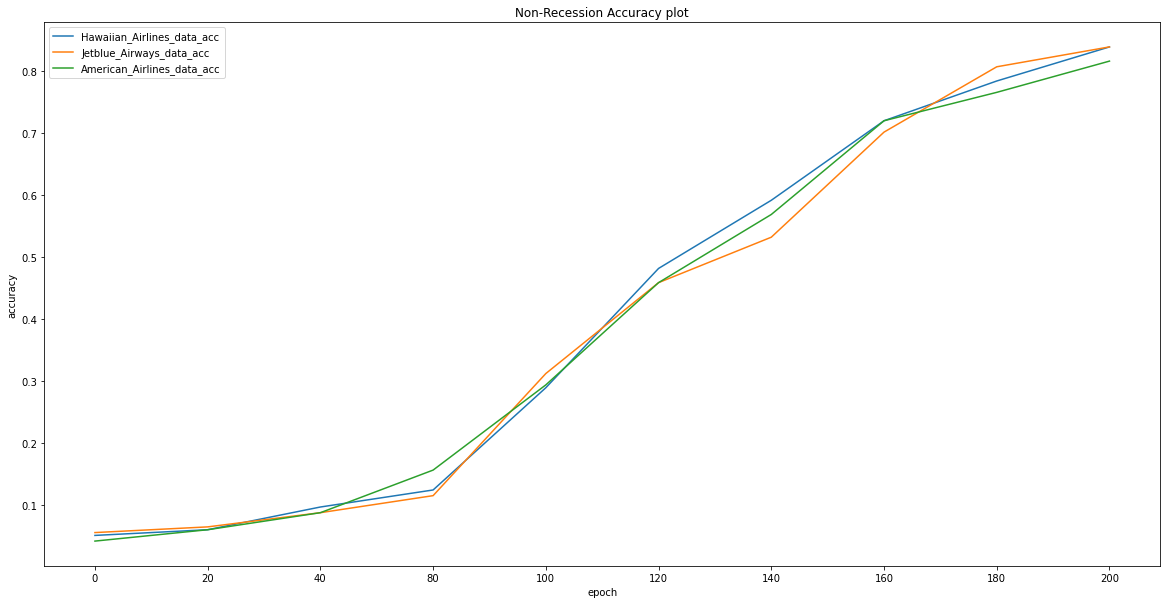

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Hawaiian_Airlines_data_acc)
plt.plot(Jetblue_Airways_data_acc)
plt.plot(American_Airlines_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Hawaiian_Airlines_data_acc','Jetblue_Airways_data_acc','American_Airlines_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'American_Airlines_data_correct_buys')

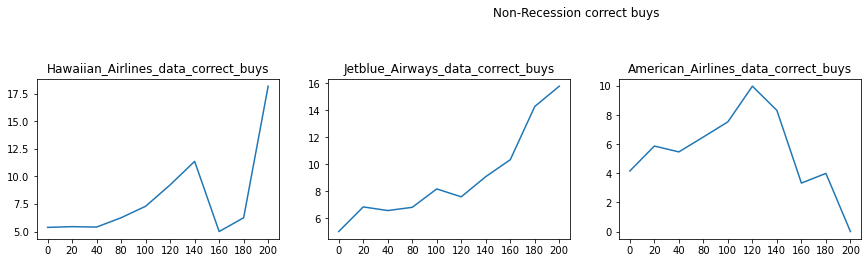

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_sells')

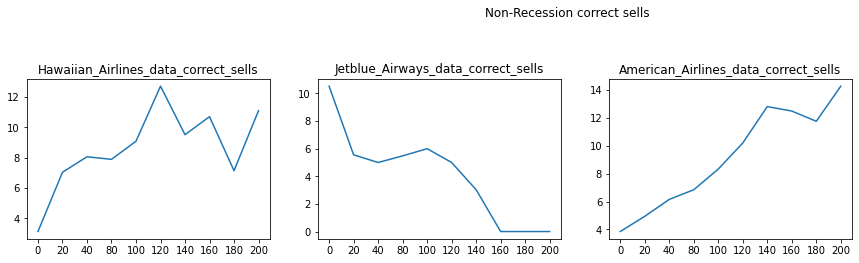

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_holds')

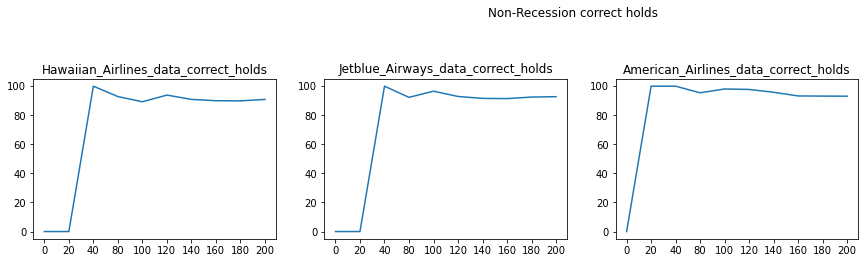

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_holds")

Text(0.5, 1.0, 'American_Airlines_data_correct_low_buys')

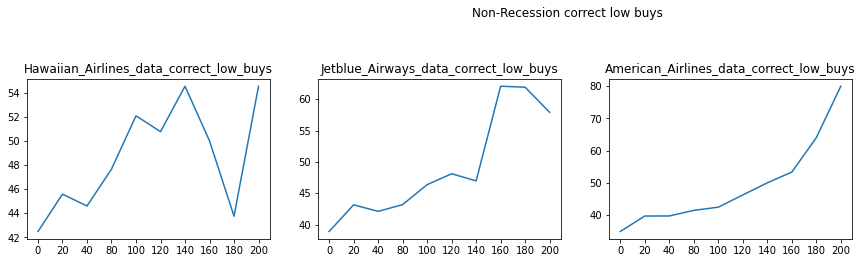

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_low_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_high_sells')

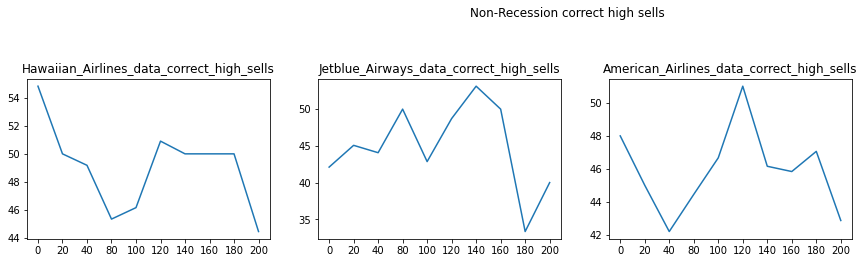

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_high_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_mid_holds')

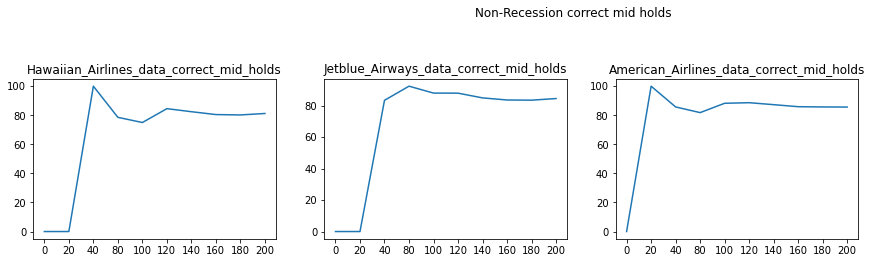

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_mid_holds")

Text(0.5, 1.0, 'American_Airlines_data_profit')

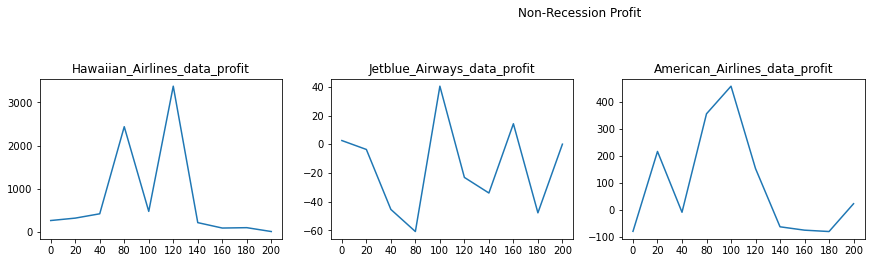

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_profit")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_profit")

In [32]:
Hawaiian_Airlines_data_acc = []
Jetblue_Airways_data_acc = []
American_Airlines_data_acc = []

Hawaiian_Airlines_data_correct_buys = []
Jetblue_Airways_data_correct_buys = []
American_Airlines_data_correct_buys = []

Hawaiian_Airlines_data_correct_sells = []
Jetblue_Airways_data_correct_sells = []
American_Airlines_data_correct_sells = []

Hawaiian_Airlines_data_correct_holds = []
Jetblue_Airways_data_correct_holds = []
American_Airlines_data_correct_holds = []

Hawaiian_Airlines_data_correct_low_buys = []
Jetblue_Airways_data_correct_low_buys = []
American_Airlines_data_correct_low_buys = []

Hawaiian_Airlines_data_correct_high_sells = []
Jetblue_Airways_data_correct_high_sells = []
American_Airlines_data_correct_high_sells = []

Hawaiian_Airlines_data_correct_mid_holds = []
Jetblue_Airways_data_correct_mid_holds = []
American_Airlines_data_correct_mid_holds = []

Hawaiian_Airlines_data_profit = []
Jetblue_Airways_data_profit = []
American_Airlines_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Hawaiian_Airlines_data_acc.append(acc[0])
    Jetblue_Airways_data_acc.append(acc[1])
    American_Airlines_data_acc.append(acc[2])
    
    Hawaiian_Airlines_data_correct_buys.append(correct_buys[0])
    Jetblue_Airways_data_correct_buys.append(correct_buys[1]) 
    American_Airlines_data_correct_buys.append(correct_buys[2]) 

    Hawaiian_Airlines_data_correct_sells.append(correct_sells[0]) 
    Jetblue_Airways_data_correct_sells.append(correct_sells[1]) 
    American_Airlines_data_correct_sells.append(correct_sells[2]) 

    Hawaiian_Airlines_data_correct_holds.append(correct_holds[0]) 
    Jetblue_Airways_data_correct_holds.append(correct_holds[1])  
    American_Airlines_data_correct_holds.append(correct_holds[2])  

    Hawaiian_Airlines_data_correct_low_buys.append(correct_low_buys[0])  
    Jetblue_Airways_data_correct_low_buys.append(correct_low_buys[1])  
    American_Airlines_data_correct_low_buys.append(correct_low_buys[2])  

    Hawaiian_Airlines_data_correct_high_sells.append(correct_high_sells[0]) 
    Jetblue_Airways_data_correct_high_sells.append(correct_high_sells[1]) 
    American_Airlines_data_correct_high_sells.append(correct_high_sells[2]) 

    Hawaiian_Airlines_data_correct_mid_holds.append(correct_mid_holds[0])  
    Jetblue_Airways_data_correct_mid_holds.append(correct_mid_holds[1])  
    American_Airlines_data_correct_mid_holds.append(correct_mid_holds[2])   

    Hawaiian_Airlines_data_profit.append(profit[0]) 
    Jetblue_Airways_data_profit.append(profit[1]) 
    American_Airlines_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


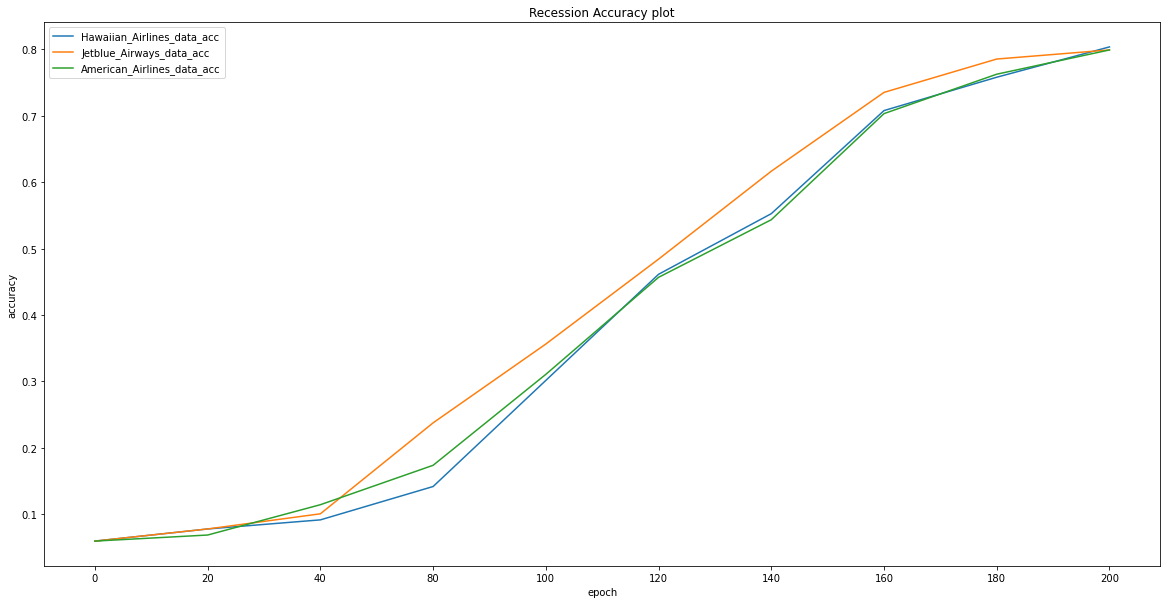

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Hawaiian_Airlines_data_acc)
plt.plot(Jetblue_Airways_data_acc)
plt.plot(American_Airlines_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Hawaiian_Airlines_data_acc','Jetblue_Airways_data_acc','American_Airlines_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'American_Airlines_data_correct_buys')

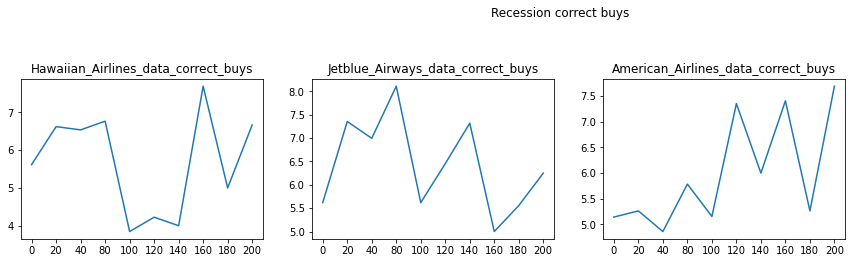

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_sells')

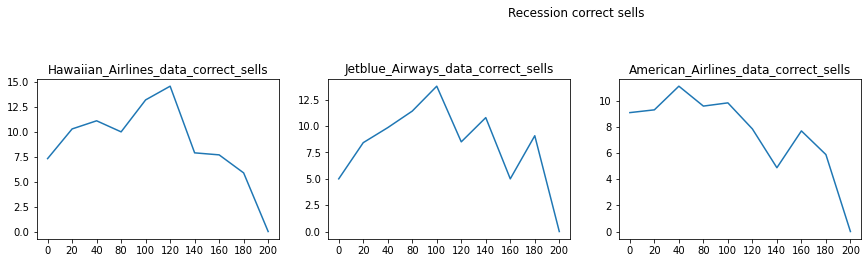

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_holds')

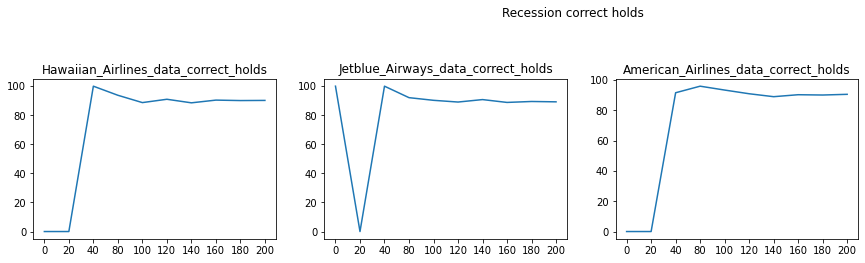

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_holds")

Text(0.5, 1.0, 'American_Airlines_data_correct_low_buys')

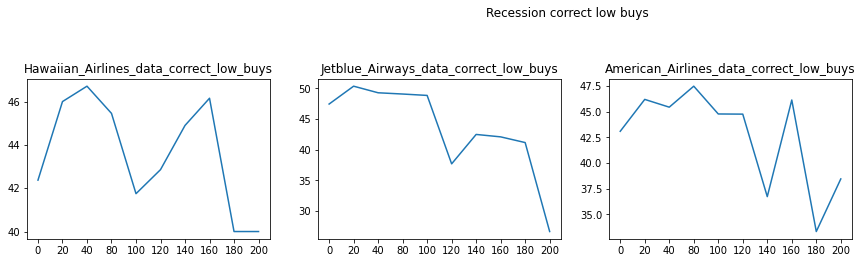

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_low_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_high_sells')

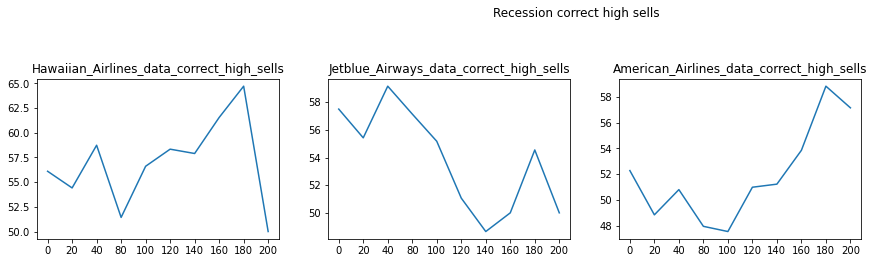

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_high_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_mid_holds')

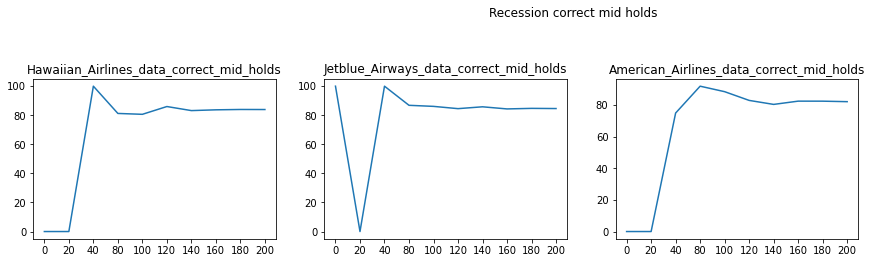

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_mid_holds")

Text(0.5, 1.0, 'American_Airlines_data_profit')

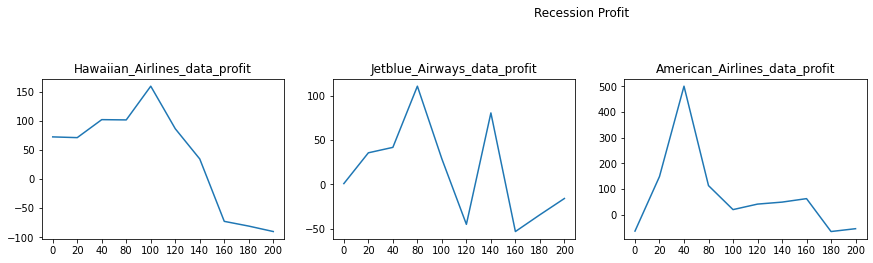

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_profit")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_profit")

## Train JetBlue Airways Corporation Stock Data

In [41]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2002-05-02    14.761481  13.724947  -5.141986  58104336.0     2.0
2002-05-03    14.562963  13.853872 -13.413429  57315261.0     2.0
2002-05-06    15.419259  14.094701  -0.086583  58757399.0     0.0
2002-05-07    16.148148  14.410616  -4.436861  61163774.0     2.0
2002-05-08    14.696296  14.454567 -37.883964  57784724.0     2.0


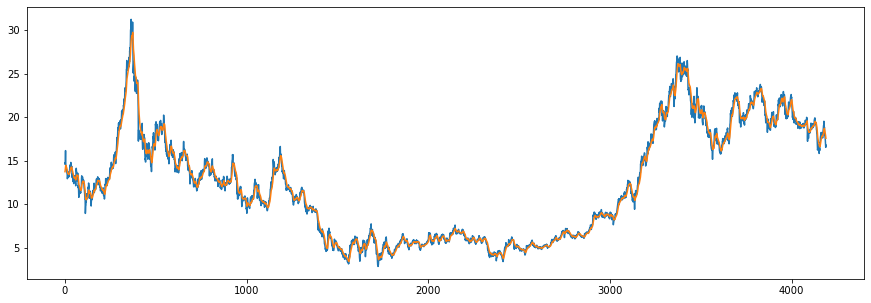

(4175, 64, 64, 1)

In [42]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/JBLU_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

In [43]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4175, 15, 1)

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [45]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4175, 64, 64, 1)

In [46]:
from collections import Counter

Counter(y)

Counter({2.0: 3801, 0.0: 191, 1.0: 183})

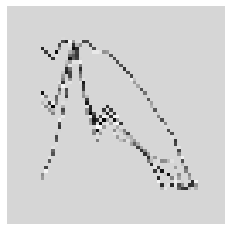

In [47]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [48]:
X = X/255

In [49]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [50]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [51]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [53]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['HA','JBLU','AAL']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'JetblueModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'JetblueModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.276688453159041, 1: 7.6255707762557075, 2: 0.3661076400306917}



RUNNING EPOCHS 0 - 20



Epoch 1/20
27/27 [==============================] - 1s 46ms/step - loss: 0.2492 - accuracy: 0.3204 - mse: 1.6919 - weighted_accuracy: 0.3244 - weighted_mse: 1.6947 - val_loss: 0.1894 - val_accuracy: 0.5102 - val_mse: 1.0867 - val_weighted_accuracy: 0.5102 - val_weighted_mse: 1.0867
Epoch 2/20
27/27 [==============================] - 0s 9ms/step - loss: 0.2111 - accuracy: 0.2470 - mse: 1.2565 - weighted_accuracy: 0.3291 - weighted_mse: 1.2693 - val_loss: 0.1859 - val_accuracy: 0.8192 - val_mse: 1.0145 - val_weighted_accuracy: 0.8192 - val_weighted_mse: 1.0145
Epoch 3/20
27/27 [==============================] - 0s 9ms/step - loss: 0.2097 - accuracy: 0.2237 - mse: 1.1240 - weighted_accuracy: 0.3353 - weighted_mse: 1.1162 - val_loss: 0.2076 - val_accuracy: 0.0443 - val_mse: 1.0454 - val_weighted_accuracy: 0.0443 - val_weighted_mse: 1.0454
Epoch 4/20
27/27 [==============================] - 0s 1

7/7 [==============================] - 0s 2ms/step - loss: 0.1937 - accuracy: 0.2557 - mse: 1.1177 - weighted_accuracy: 0.2557 - weighted_mse: 1.1177
Test loss: 0.19368617236614227
Test accuracy: 0.2557077705860138


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 103
actual holds but predicted sell: 53
actual predicted holds: 43
Percentage buys correct: 6.1946902654867255%
Percentage sells correct: 10.0%
Percentage holds correct: 93.47826086956522%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 42.857142857142854%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 84.78260869565217%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Price increase

7/7 [==============================] - 0s 2ms/step - loss: 0.1931 - accuracy: 0.2511 - mse: 1.1160 - weighted_accuracy: 0.2511 - weighted_mse: 1.1160
Test loss: 0.19312870502471924
Test accuracy: 0.2511415481567383


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 4
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 92
actual holds but predicted sell: 61
actual predicted holds: 44
Percentage buys correct: 6.796116504854369%
Percentage sells correct: 6.0606060606060606%
Percentage holds correct: 88.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 48.03921568627451%
Percentage high sells correct: 53.03030303030303%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


Price increase from previously

7/7 [==============================] - 0s 2ms/step - loss: 0.1932 - accuracy: 0.2146 - mse: 1.1252 - weighted_accuracy: 0.2146 - weighted_mse: 1.1252
Test loss: 0.19315066933631897
Test accuracy: 0.21461187303066254


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 5
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 100
actual holds but predicted sell: 63
actual predicted holds: 35
Percentage buys correct: 6.25%
Percentage sells correct: 7.246376811594203%
Percentage holds correct: 92.10526315789474%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 45.945945945945944%
Percentage high sells correct: 47.82608695652174%
Percentage mid holds correct: 89.47368421052632%


Capital: 100
Share price: $0.9185394706586716
Shares owned at the moment: 108
Cash capital at the moment: $0.5249309460778306


Price increase fr

Epoch 9/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1847 - accuracy: 0.2542 - mse: 1.2920 - weighted_accuracy: 0.5068 - weighted_mse: 1.2136 - val_loss: 0.1938 - val_accuracy: 0.2850 - val_mse: 1.0903 - val_weighted_accuracy: 0.2850 - val_weighted_mse: 1.0903
Epoch 10/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1833 - accuracy: 0.1605 - mse: 1.2976 - weighted_accuracy: 0.4927 - weighted_mse: 1.2242 - val_loss: 0.2079 - val_accuracy: 0.0683 - val_mse: 1.2316 - val_weighted_accuracy: 0.0683 - val_weighted_mse: 1.2316
Epoch 11/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1838 - accuracy: 0.2296 - mse: 1.3028 - weighted_accuracy: 0.5205 - weighted_mse: 1.2257 - val_loss: 0.1948 - val_accuracy: 0.3042 - val_mse: 1.1297 - val_weighted_accuracy: 0.3042 - val_weighted_mse: 1.1297
Epoch 12/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1831 - accuracy: 0.2578 - mse: 1.2789 - weighted_accuracy: 0.5146 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.1994 - accuracy: 0.2603 - mse: 1.0214 - weighted_accuracy: 0.2603 - weighted_mse: 1.0214
Test loss: 0.1994449943304062
Test accuracy: 0.2602739632129669


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 70
actual holds but predicted sell: 85
actual predicted holds: 44
Percentage buys correct: 7.792207792207792%
Percentage sells correct: 7.526881720430108%
Percentage holds correct: 89.79591836734694%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 46.05263157894737%
Percentage high sells correct: 49.46236559139785%
Percentage mid holds correct: 81.63265306122449%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Price 

7/7 [==============================] - 0s 2ms/step - loss: 0.2011 - accuracy: 0.2831 - mse: 1.0400 - weighted_accuracy: 0.2831 - weighted_mse: 1.0400
Test loss: 0.20106519758701324
Test accuracy: 0.2831050157546997


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 54
actual holds but predicted sell: 92
actual predicted holds: 51
Percentage buys correct: 6.557377049180328%
Percentage sells correct: 7.070707070707071%
Percentage holds correct: 86.44067796610169%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 46.666666666666664%
Percentage high sells correct: 49.494949494949495%
Percentage mid holds correct: 83.05084745762711%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


Pri

7/7 [==============================] - 0s 2ms/step - loss: 0.2012 - accuracy: 0.2831 - mse: 1.0598 - weighted_accuracy: 0.2831 - weighted_mse: 1.0598
Test loss: 0.20121601223945618
Test accuracy: 0.2831050157546997


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 62
actual holds but predicted sell: 88
actual predicted holds: 48
Percentage buys correct: 8.571428571428571%
Percentage sells correct: 8.24742268041237%
Percentage holds correct: 92.3076923076923%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 47.82608695652174%
Percentage high sells correct: 54.63917525773196%
Percentage mid holds correct: 86.53846153846153%


Capital: 100
Share price: $0.9185394706586716
Shares owned at the moment: 108
Cash capital at the moment: $0.5249309460778306


Price inc

Epoch 6/20
27/27 [==============================] - 0s 11ms/step - loss: 0.1721 - accuracy: 0.2575 - mse: 1.3819 - weighted_accuracy: 0.5514 - weighted_mse: 1.3490 - val_loss: 0.2038 - val_accuracy: 0.2048 - val_mse: 1.1094 - val_weighted_accuracy: 0.2048 - val_weighted_mse: 1.1094
Epoch 7/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1733 - accuracy: 0.2135 - mse: 1.3443 - weighted_accuracy: 0.5619 - weighted_mse: 1.2702 - val_loss: 0.2070 - val_accuracy: 0.1497 - val_mse: 1.1889 - val_weighted_accuracy: 0.1497 - val_weighted_mse: 1.1889
Epoch 8/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1685 - accuracy: 0.2889 - mse: 1.3951 - weighted_accuracy: 0.5658 - weighted_mse: 1.3751 - val_loss: 0.1993 - val_accuracy: 0.2060 - val_mse: 1.1858 - val_weighted_accuracy: 0.2060 - val_weighted_mse: 1.1858
Epoch 9/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1706 - accuracy: 0.2623 - mse: 1.3589 - weighted_accuracy: 0.5662 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1901 - accuracy: 0.3014 - mse: 1.2259 - weighted_accuracy: 0.3014 - weighted_mse: 1.2259
Test loss: 0.19008509814739227
Test accuracy: 0.30136987566947937


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 70
actual holds but predicted sell: 77
actual predicted holds: 52
Percentage buys correct: 8.974358974358974%
Percentage sells correct: 8.13953488372093%
Percentage holds correct: 94.54545454545455%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 46.753246753246756%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Price increase from previously

7/7 [==============================] - 0s 2ms/step - loss: 0.1921 - accuracy: 0.3014 - mse: 1.2429 - weighted_accuracy: 0.3014 - weighted_mse: 1.2429
Test loss: 0.19206582009792328
Test accuracy: 0.30136987566947937


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 53
actual holds but predicted sell: 89
actual predicted holds: 55
Percentage buys correct: 6.779661016949152%
Percentage sells correct: 7.216494845360825%
Percentage holds correct: 87.3015873015873%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 48.45360824742268%
Percentage mid holds correct: 84.12698412698413%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


Price increase fro

7/7 [==============================] - 0s 2ms/step - loss: 0.1937 - accuracy: 0.2968 - mse: 1.2841 - weighted_accuracy: 0.2968 - weighted_mse: 1.2841
Test loss: 0.19372840225696564
Test accuracy: 0.29680365324020386


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 64
actual holds but predicted sell: 84
actual predicted holds: 50
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 9.473684210526315%
Percentage holds correct: 96.15384615384616%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 49.29577464788732%
Percentage high sells correct: 56.8421052631579%
Percentage mid holds correct: 90.38461538461539%


Capital: 100
Share price: $0.9185394706586716
Shares owned at the moment: 108
Cash capital at the moment: $0.5249309460778306


Price i

Epoch 6/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1573 - accuracy: 0.2928 - mse: 1.4486 - weighted_accuracy: 0.6332 - weighted_mse: 1.4228 - val_loss: 0.1936 - val_accuracy: 0.2527 - val_mse: 1.2210 - val_weighted_accuracy: 0.2527 - val_weighted_mse: 1.2210
Epoch 7/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1560 - accuracy: 0.2811 - mse: 1.4667 - weighted_accuracy: 0.6568 - weighted_mse: 1.4475 - val_loss: 0.1911 - val_accuracy: 0.2814 - val_mse: 1.1337 - val_weighted_accuracy: 0.2814 - val_weighted_mse: 1.1337
Epoch 8/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1560 - accuracy: 0.2820 - mse: 1.4188 - weighted_accuracy: 0.6401 - weighted_mse: 1.4308 - val_loss: 0.1960 - val_accuracy: 0.2168 - val_mse: 1.2153 - val_weighted_accuracy: 0.2168 - val_weighted_mse: 1.2153
Epoch 9/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1584 - accuracy: 0.2772 - mse: 1.4190 - weighted_accuracy: 0.6154 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.1887 - accuracy: 0.3151 - mse: 1.3108 - weighted_accuracy: 0.3151 - weighted_mse: 1.3108
Test loss: 0.18873710930347443
Test accuracy: 0.31506848335266113


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 57
actual holds but predicted sell: 87
actual predicted holds: 55
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 8.24742268041237%
Percentage holds correct: 93.22033898305085%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 52.38095238095238%
Percentage high sells correct: 47.422680412371136%
Percentage mid holds correct: 82.75862068965517%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Pric

7/7 [==============================] - 0s 2ms/step - loss: 0.1915 - accuracy: 0.3151 - mse: 1.3194 - weighted_accuracy: 0.3151 - weighted_mse: 1.3194
Test loss: 0.19151726365089417
Test accuracy: 0.31506848335266113


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 47
actual holds but predicted sell: 93
actual predicted holds: 57
Percentage buys correct: 9.25925925925926%
Percentage sells correct: 6.930693069306931%
Percentage holds correct: 89.0625%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.943396226415096%
Percentage high sells correct: 52.475247524752476%
Percentage mid holds correct: 82.8125%


Capital: 100
Share price: $0.707959263378032
Shares owned at the moment: 140
Cash capital at the moment: $0.6131388106749682


Price increase from previ

7/7 [==============================] - 0s 2ms/step - loss: 0.1939 - accuracy: 0.2968 - mse: 1.3704 - weighted_accuracy: 0.2968 - weighted_mse: 1.3704
Test loss: 0.19392342865467072
Test accuracy: 0.29680365324020386


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 61
actual holds but predicted sell: 86
actual predicted holds: 51
Percentage buys correct: 7.462686567164179%
Percentage sells correct: 9.278350515463918%
Percentage holds correct: 92.72727272727273%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 54.54545454545455%
Percentage high sells correct: 54.63917525773196%
Percentage mid holds correct: 83.63636363636364%


Capital: 100
Share price: $0.9185394706586716
Shares owned at the moment: 108
Cash capital at the moment: $0.5249309460778306


Price 

Epoch 4/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1467 - accuracy: 0.3168 - mse: 1.5339 - weighted_accuracy: 0.6716 - weighted_mse: 1.5855 - val_loss: 0.1930 - val_accuracy: 0.2862 - val_mse: 1.3233 - val_weighted_accuracy: 0.2862 - val_weighted_mse: 1.3233
Epoch 5/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1469 - accuracy: 0.2907 - mse: 1.4839 - weighted_accuracy: 0.6684 - weighted_mse: 1.5158 - val_loss: 0.1856 - val_accuracy: 0.3329 - val_mse: 1.2499 - val_weighted_accuracy: 0.3329 - val_weighted_mse: 1.2499
Epoch 6/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1485 - accuracy: 0.3108 - mse: 1.4864 - weighted_accuracy: 0.6592 - weighted_mse: 1.5085 - val_loss: 0.1863 - val_accuracy: 0.3293 - val_mse: 1.2913 - val_weighted_accuracy: 0.3293 - val_weighted_mse: 1.2913
Epoch 7/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1435 - accuracy: 0.3114 - mse: 1.5525 - weighted_accuracy: 0.6768 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.1770 - accuracy: 0.4064 - mse: 1.3468 - weighted_accuracy: 0.4064 - weighted_mse: 1.3468
Test loss: 0.1769612431526184
Test accuracy: 0.4063926935195923


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 2
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 44
actual holds but predicted sell: 75
actual predicted holds: 80
Percentage buys correct: 6.382978723404255%
Percentage sells correct: 7.228915662650603%
Percentage holds correct: 89.88764044943821%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 48.93617021276596%
Percentage high sells correct: 48.19277108433735%
Percentage mid holds correct: 80.68181818181819%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Price 

7/7 [==============================] - 0s 2ms/step - loss: 0.1797 - accuracy: 0.4247 - mse: 1.3652 - weighted_accuracy: 0.4247 - weighted_mse: 1.3652
Test loss: 0.17965959012508392
Test accuracy: 0.42465752363204956


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 39
actual holds but predicted sell: 76
actual predicted holds: 82
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 8.433734939759036%
Percentage holds correct: 89.1304347826087%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 53.48837209302326%
Percentage high sells correct: 54.21686746987952%
Percentage mid holds correct: 83.69565217391305%


Capital: 100
Share price: $0.707959263378032
Shares owned at the moment: 140
Cash capital at the moment: $0.6131388106749682


Price i

7/7 [==============================] - 0s 2ms/step - loss: 0.1850 - accuracy: 0.4155 - mse: 1.4430 - weighted_accuracy: 0.4155 - weighted_mse: 1.4430
Test loss: 0.1849905252456665
Test accuracy: 0.4155251085758209


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 3
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 44
actual holds but predicted sell: 77
actual predicted holds: 77
Percentage buys correct: 10.0%
Percentage sells correct: 10.112359550561798%
Percentage holds correct: 96.25%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 57.142857142857146%
Percentage high sells correct: 57.30337078651685%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.6670229259663452
Shares owned at the moment: 149
Cash capital at the moment: $0.34027138709986104


Price increase from previously bought: -52.

Epoch 7/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1304 - accuracy: 0.4335 - mse: 1.7729 - weighted_accuracy: 0.7458 - weighted_mse: 1.8448 - val_loss: 0.1736 - val_accuracy: 0.4671 - val_mse: 1.4908 - val_weighted_accuracy: 0.4671 - val_weighted_mse: 1.4908
Epoch 8/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1278 - accuracy: 0.4377 - mse: 1.7066 - weighted_accuracy: 0.7371 - weighted_mse: 1.8786 - val_loss: 0.1801 - val_accuracy: 0.4132 - val_mse: 1.4914 - val_weighted_accuracy: 0.4132 - val_weighted_mse: 1.4914
Epoch 9/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1300 - accuracy: 0.4269 - mse: 1.8142 - weighted_accuracy: 0.7294 - weighted_mse: 1.9575 - val_loss: 0.1709 - val_accuracy: 0.4790 - val_mse: 1.4040 - val_weighted_accuracy: 0.4790 - val_weighted_mse: 1.4040
Epoch 10/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1289 - accuracy: 0.4689 - mse: 1.7522 - weighted_accuracy: 0.7275 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1623 - accuracy: 0.5251 - mse: 1.4738 - weighted_accuracy: 0.5251 - weighted_mse: 1.4738
Test loss: 0.1623292863368988
Test accuracy: 0.5251141786575317


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 2
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 39
actual holds but predicted sell: 53
actual predicted holds: 107
Percentage buys correct: 4.878048780487805%
Percentage sells correct: 9.836065573770492%
Percentage holds correct: 91.45299145299145%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 48.78048780487805%
Percentage high sells correct: 52.459016393442624%
Percentage mid holds correct: 83.62068965517241%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Pric

7/7 [==============================] - 0s 2ms/step - loss: 0.1659 - accuracy: 0.5160 - mse: 1.4905 - weighted_accuracy: 0.5160 - weighted_mse: 1.4905
Test loss: 0.16594181954860687
Test accuracy: 0.5159817337989807


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 7
actual holds but predicted buy: 35
actual holds but predicted sell: 58
actual predicted holds: 104
Percentage buys correct: 10.256410256410257%
Percentage sells correct: 7.936507936507937%
Percentage holds correct: 88.88888888888889%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 52.63157894736842%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 83.76068376068376%


Capital: 100
Share price: $0.707959263378032
Shares owned at the moment: 140
Cash capital at the moment: $0.6131388106749682


Pric

7/7 [==============================] - 0s 2ms/step - loss: 0.1734 - accuracy: 0.5160 - mse: 1.5906 - weighted_accuracy: 0.5160 - weighted_mse: 1.5906
Test loss: 0.17342668771743774
Test accuracy: 0.5159817337989807


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 5
actual holds but predicted buy: 36
actual holds but predicted sell: 61
actual predicted holds: 101
Percentage buys correct: 12.195121951219512%
Percentage sells correct: 10.144927536231885%
Percentage holds correct: 92.66055045871559%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 65.0%
Percentage high sells correct: 62.31884057971015%
Percentage mid holds correct: 84.40366972477064%


Capital: 100
Share price: $0.6670229259663452
Shares owned at the moment: 149
Cash capital at the moment: $0.34027138709986104


Price increase f

Epoch 7/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1146 - accuracy: 0.5500 - mse: 2.0148 - weighted_accuracy: 0.7971 - weighted_mse: 2.2314 - val_loss: 0.1564 - val_accuracy: 0.6072 - val_mse: 1.5750 - val_weighted_accuracy: 0.6072 - val_weighted_mse: 1.5750
Epoch 8/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1173 - accuracy: 0.5350 - mse: 1.8981 - weighted_accuracy: 0.7685 - weighted_mse: 2.1581 - val_loss: 0.1587 - val_accuracy: 0.5904 - val_mse: 1.5586 - val_weighted_accuracy: 0.5904 - val_weighted_mse: 1.5586
Epoch 9/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1144 - accuracy: 0.5326 - mse: 1.9992 - weighted_accuracy: 0.7827 - weighted_mse: 2.2671 - val_loss: 0.1556 - val_accuracy: 0.6120 - val_mse: 1.5684 - val_weighted_accuracy: 0.6120 - val_weighted_mse: 1.5684
Epoch 10/20
27/27 [==============================] - 0s 9ms/step - loss: 0.1185 - accuracy: 0.5778 - mse: 1.9059 - weighted_accuracy: 0.7700 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1497 - accuracy: 0.6210 - mse: 1.6544 - weighted_accuracy: 0.6210 - weighted_mse: 1.6544
Test loss: 0.1497400850057602
Test accuracy: 0.621004581451416


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 2
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 29
actual holds but predicted sell: 39
actual predicted holds: 131
Percentage buys correct: 3.3333333333333335%
Percentage sells correct: 8.88888888888889%
Percentage holds correct: 90.97222222222223%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 50.0%
Percentage high sells correct: 57.77777777777778%
Percentage mid holds correct: 83.91608391608392%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Price increase from

7/7 [==============================] - 0s 2ms/step - loss: 0.1518 - accuracy: 0.6347 - mse: 1.6694 - weighted_accuracy: 0.6347 - weighted_mse: 1.6694
Test loss: 0.1517605483531952
Test accuracy: 0.6347032189369202


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 8
actual holds but predicted buy: 26
actual holds but predicted sell: 39
actual predicted holds: 132
Percentage buys correct: 10.344827586206897%
Percentage sells correct: 9.30232558139535%
Percentage holds correct: 89.79591836734694%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 51.724137931034484%
Percentage high sells correct: 62.7906976744186%
Percentage mid holds correct: 85.61643835616438%


Capital: 100
Share price: $0.707959263378032
Shares owned at the moment: 140
Cash capital at the moment: $0.6131388106749682


Price i

7/7 [==============================] - 0s 2ms/step - loss: 0.1598 - accuracy: 0.5799 - mse: 1.7714 - weighted_accuracy: 0.5799 - weighted_mse: 1.7714
Test loss: 0.15978094935417175
Test accuracy: 0.5799086689949036


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 6
actual holds but predicted buy: 27
actual holds but predicted sell: 53
actual predicted holds: 118
Percentage buys correct: 10.0%
Percentage sells correct: 10.169491525423728%
Percentage holds correct: 90.76923076923077%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 63.333333333333336%
Percentage high sells correct: 61.016949152542374%
Percentage mid holds correct: 82.94573643410853%


Capital: 100
Share price: $0.6670229259663452
Shares owned at the moment: 149
Cash capital at the moment: $0.34027138709986104


Price increase 

27/27 [==============================] - 0s 9ms/step - loss: 0.0973 - accuracy: 0.6817 - mse: 2.3096 - weighted_accuracy: 0.8459 - weighted_mse: 2.8331 - val_loss: 0.1358 - val_accuracy: 0.7198 - val_mse: 1.8423 - val_weighted_accuracy: 0.7198 - val_weighted_mse: 1.8423
Epoch 11/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0963 - accuracy: 0.6802 - mse: 2.3620 - weighted_accuracy: 0.8431 - weighted_mse: 2.8724 - val_loss: 0.1330 - val_accuracy: 0.7401 - val_mse: 1.8255 - val_weighted_accuracy: 0.7401 - val_weighted_mse: 1.8255
Epoch 12/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0994 - accuracy: 0.6814 - mse: 2.3551 - weighted_accuracy: 0.8286 - weighted_mse: 2.9228 - val_loss: 0.1498 - val_accuracy: 0.6611 - val_mse: 1.8946 - val_weighted_accuracy: 0.6611 - val_weighted_mse: 1.8946
Epoch 13/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0998 - accuracy: 0.6671 - mse: 2.3698 - weighted_accuracy: 0.8174 - weighted_mse: 2.9112

7/7 [==============================] - 0s 2ms/step - loss: 0.1207 - accuracy: 0.7890 - mse: 1.9970 - weighted_accuracy: 0.7890 - weighted_mse: 1.9970
Test loss: 0.12072713673114777
Test accuracy: 0.78899085521698


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 12
actual holds but predicted sell: 19
actual predicted holds: 169
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 92.34972677595628%
actual buys: 10
actual sells: 8
actual holds: 200


Percentage low buys correct: 50.0%
Percentage high sells correct: 52.38095238095238%
Percentage mid holds correct: 82.96703296703296%


Capital: 100
Share price: $0.396308035393673
Shares owned at the moment: 251
Cash capital at the moment: $0.25313149475759644


Price increase from p

7/7 [==============================] - 0s 2ms/step - loss: 0.1271 - accuracy: 0.7260 - mse: 2.0933 - weighted_accuracy: 0.7260 - weighted_mse: 2.0933
Test loss: 0.1271175742149353
Test accuracy: 0.7260273694992065


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 14
actual holds but predicted sell: 29
actual predicted holds: 155
Percentage buys correct: 12.5%
Percentage sells correct: 6.451612903225806%
Percentage holds correct: 90.11627906976744%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 62.5%
Percentage high sells correct: 54.83870967741935%
Percentage mid holds correct: 81.28654970760233%


Capital: 100
Share price: $0.6670229259663452
Shares owned at the moment: 149
Cash capital at the moment: $0.34027138709986104


Price increase from previously 

27/27 [==============================] - 0s 9ms/step - loss: 0.0836 - accuracy: 0.7656 - mse: 2.8092 - weighted_accuracy: 0.8551 - weighted_mse: 3.6473 - val_loss: 0.1180 - val_accuracy: 0.7928 - val_mse: 2.1578 - val_weighted_accuracy: 0.7928 - val_weighted_mse: 2.1578
Epoch 16/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0804 - accuracy: 0.7692 - mse: 2.9078 - weighted_accuracy: 0.8755 - weighted_mse: 3.7700 - val_loss: 0.1246 - val_accuracy: 0.7749 - val_mse: 2.1866 - val_weighted_accuracy: 0.7749 - val_weighted_mse: 2.1866
Epoch 17/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0829 - accuracy: 0.7632 - mse: 2.8709 - weighted_accuracy: 0.8582 - weighted_mse: 3.7077 - val_loss: 0.1231 - val_accuracy: 0.7737 - val_mse: 2.1429 - val_weighted_accuracy: 0.7737 - val_weighted_mse: 2.1429
Epoch 18/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0839 - accuracy: 0.7593 - mse: 2.8309 - weighted_accuracy: 0.8594 - weighted_mse: 3.8143

7/7 [==============================] - 0s 2ms/step - loss: 0.1093 - accuracy: 0.8219 - mse: 2.5191 - weighted_accuracy: 0.8219 - weighted_mse: 2.5191
Test loss: 0.10927144438028336
Test accuracy: 0.8219178318977356


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 12
actual holds but predicted buy: 7
actual holds but predicted sell: 10
actual predicted holds: 180
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 89.10891089108911%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 57.142857142857146%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 83.58208955223881%


Capital: 100
Share price: $0.707959263378032
Shares owned at the moment: 140
Cash capital at the moment: $0.6131388106749682


Price increase from previously bought: -77.79


RUNNING EPOCHS 180 - 200



Epoch 1/20
27/27 [==============================] - 0s 12ms/step - loss: 0.0762 - accuracy: 0.7683 - mse: 3.0610 - weighted_accuracy: 0.8754 - weighted_mse: 4.0314 - val_loss: 0.1181 - val_accuracy: 0.7940 - val_mse: 2.3321 - val_weighted_accuracy: 0.7940 - val_weighted_mse: 2.3321
Epoch 2/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0750 - accuracy: 0.7862 - mse: 3.1311 - weighted_accuracy: 0.8772 - weighted_mse: 4.0284 - val_loss: 0.1157 - val_accuracy: 0.8012 - val_mse: 2.2666 - val_weighted_accuracy: 0.8012 - val_weighted_mse: 2.2666
Epoch 3/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0747 - accuracy: 0.7689 - mse: 2.9965 - weighted_accuracy: 0.8841 - weighted_mse: 3.7933 - val_loss: 0.1183 - val_accuracy: 0.7916 - val_mse: 2.4854 - val_weighted_accuracy: 0.7916 - val_weighted_mse: 2.4854
Epoch 4/20
27/27 [==============================] - 0s 9ms/step - loss: 0.0782 - accuracy: 0.7781 - mse: 3.0283 - weighted_a

7/7 [==============================] - 0s 2ms/step - loss: 0.0935 - accuracy: 0.8578 - mse: 2.8545 - weighted_accuracy: 0.8578 - weighted_mse: 2.8545
Test loss: 0.09345506876707077
Test accuracy: 0.857798159122467


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 7
actual holds but predicted sell: 7
actual predicted holds: 186
Percentage buys correct: 12.5%
Percentage sells correct: 0.0%
Percentage holds correct: 91.6256157635468%
actual buys: 10
actual sells: 8
actual holds: 200


Percentage low buys correct: 50.0%
Percentage high sells correct: 28.571428571428573%
Percentage mid holds correct: 82.17821782178218%


Capital: 100
Share price: $0.16403401889067815
Shares owned at the moment: 607
Cash capital at the moment: $0.15753674732509637


Price increase from previously bought: 93.37221

2         -63.196503  


In [54]:
Hawaiian_Airlines_data_acc = []
Jetblue_Airways_data_acc = []
American_Airlines_data_acc = []

Hawaiian_Airlines_data_correct_buys = []
Jetblue_Airways_data_correct_buys = []
American_Airlines_data_correct_buys = []

Hawaiian_Airlines_data_correct_sells = []
Jetblue_Airways_data_correct_sells = []
American_Airlines_data_correct_sells = []

Hawaiian_Airlines_data_correct_holds = []
Jetblue_Airways_data_correct_holds = []
American_Airlines_data_correct_holds = []

Hawaiian_Airlines_data_correct_low_buys = []
Jetblue_Airways_data_correct_low_buys = []
American_Airlines_data_correct_low_buys = []

Hawaiian_Airlines_data_correct_high_sells = []
Jetblue_Airways_data_correct_high_sells = []
American_Airlines_data_correct_high_sells = []

Hawaiian_Airlines_data_correct_mid_holds = []
Jetblue_Airways_data_correct_mid_holds = []
American_Airlines_data_correct_mid_holds = []

Hawaiian_Airlines_data_profit = []
Jetblue_Airways_data_profit = []
American_Airlines_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Hawaiian_Airlines_data_acc.append(acc[0])
    Jetblue_Airways_data_acc.append(acc[1])
    American_Airlines_data_acc.append(acc[2])
    
    Hawaiian_Airlines_data_correct_buys.append(correct_buys[0])
    Jetblue_Airways_data_correct_buys.append(correct_buys[1]) 
    American_Airlines_data_correct_buys.append(correct_buys[2]) 

    Hawaiian_Airlines_data_correct_sells.append(correct_sells[0]) 
    Jetblue_Airways_data_correct_sells.append(correct_sells[1]) 
    American_Airlines_data_correct_sells.append(correct_sells[2]) 

    Hawaiian_Airlines_data_correct_holds.append(correct_holds[0]) 
    Jetblue_Airways_data_correct_holds.append(correct_holds[1])  
    American_Airlines_data_correct_holds.append(correct_holds[2])  

    Hawaiian_Airlines_data_correct_low_buys.append(correct_low_buys[0])  
    Jetblue_Airways_data_correct_low_buys.append(correct_low_buys[1])  
    American_Airlines_data_correct_low_buys.append(correct_low_buys[2])  

    Hawaiian_Airlines_data_correct_high_sells.append(correct_high_sells[0]) 
    Jetblue_Airways_data_correct_high_sells.append(correct_high_sells[1]) 
    American_Airlines_data_correct_high_sells.append(correct_high_sells[2]) 

    Hawaiian_Airlines_data_correct_mid_holds.append(correct_mid_holds[0])  
    Jetblue_Airways_data_correct_mid_holds.append(correct_mid_holds[1])  
    American_Airlines_data_correct_mid_holds.append(correct_mid_holds[2])   

    Hawaiian_Airlines_data_profit.append(profit[0]) 
    Jetblue_Airways_data_profit.append(profit[1]) 
    American_Airlines_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


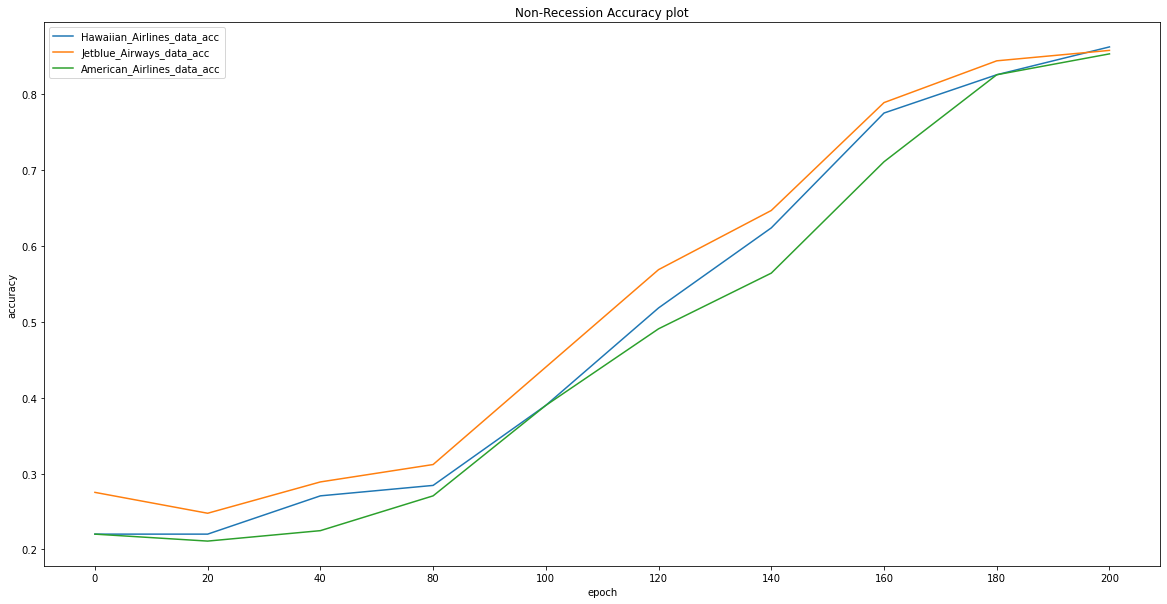

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Hawaiian_Airlines_data_acc)
plt.plot(Jetblue_Airways_data_acc)
plt.plot(American_Airlines_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Hawaiian_Airlines_data_acc','Jetblue_Airways_data_acc','American_Airlines_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'American_Airlines_data_correct_buys')

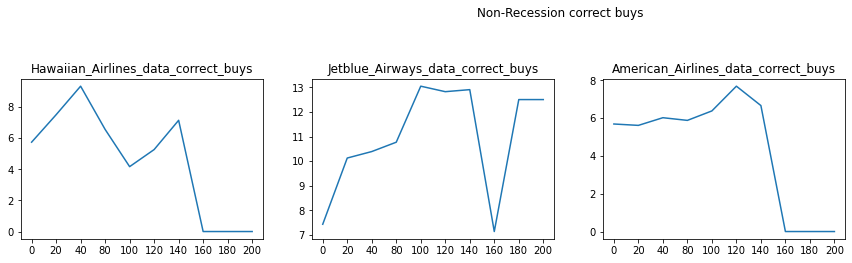

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_sells')

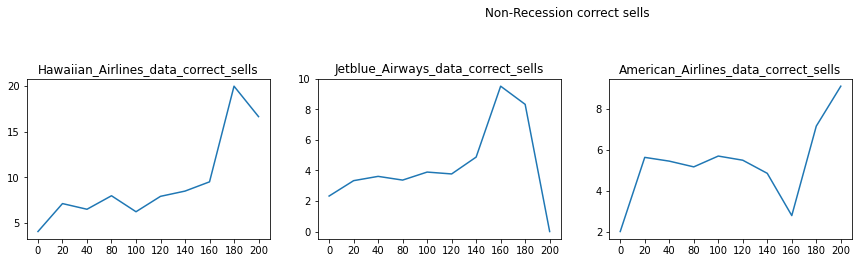

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_holds')

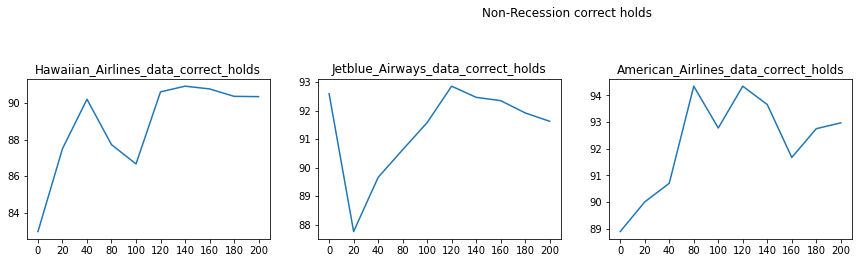

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_holds")

Text(0.5, 1.0, 'American_Airlines_data_correct_low_buys')

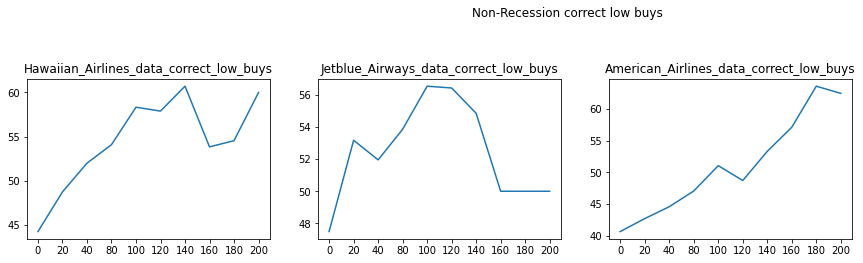

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_low_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_high_sells')

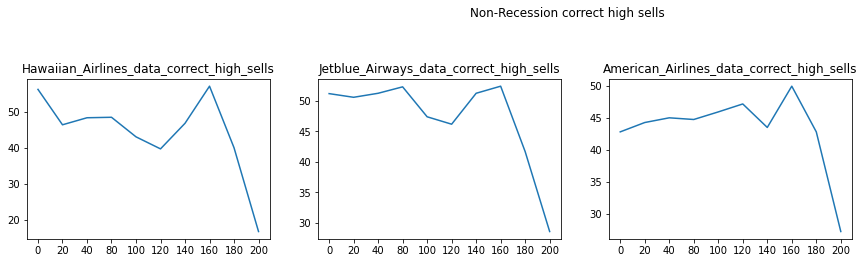

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_high_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_mid_holds')

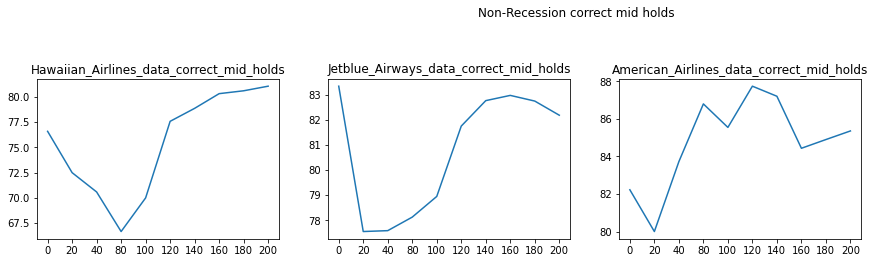

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_mid_holds")

Text(0.5, 1.0, 'American_Airlines_data_profit')

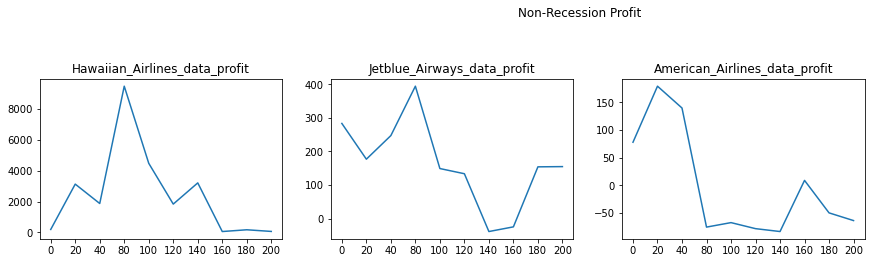

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_profit")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_profit")

In [63]:
Hawaiian_Airlines_data_acc = []
Jetblue_Airways_data_acc = []
American_Airlines_data_acc = []

Hawaiian_Airlines_data_correct_buys = []
Jetblue_Airways_data_correct_buys = []
American_Airlines_data_correct_buys = []

Hawaiian_Airlines_data_correct_sells = []
Jetblue_Airways_data_correct_sells = []
American_Airlines_data_correct_sells = []

Hawaiian_Airlines_data_correct_holds = []
Jetblue_Airways_data_correct_holds = []
American_Airlines_data_correct_holds = []

Hawaiian_Airlines_data_correct_low_buys = []
Jetblue_Airways_data_correct_low_buys = []
American_Airlines_data_correct_low_buys = []

Hawaiian_Airlines_data_correct_high_sells = []
Jetblue_Airways_data_correct_high_sells = []
American_Airlines_data_correct_high_sells = []

Hawaiian_Airlines_data_correct_mid_holds = []
Jetblue_Airways_data_correct_mid_holds = []
American_Airlines_data_correct_mid_holds = []

Hawaiian_Airlines_data_profit = []
Jetblue_Airways_data_profit = []
American_Airlines_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Hawaiian_Airlines_data_acc.append(acc[0])
    Jetblue_Airways_data_acc.append(acc[1])
    American_Airlines_data_acc.append(acc[2])
    
    Hawaiian_Airlines_data_correct_buys.append(correct_buys[0])
    Jetblue_Airways_data_correct_buys.append(correct_buys[1]) 
    American_Airlines_data_correct_buys.append(correct_buys[2]) 

    Hawaiian_Airlines_data_correct_sells.append(correct_sells[0]) 
    Jetblue_Airways_data_correct_sells.append(correct_sells[1]) 
    American_Airlines_data_correct_sells.append(correct_sells[2]) 

    Hawaiian_Airlines_data_correct_holds.append(correct_holds[0]) 
    Jetblue_Airways_data_correct_holds.append(correct_holds[1])  
    American_Airlines_data_correct_holds.append(correct_holds[2])  

    Hawaiian_Airlines_data_correct_low_buys.append(correct_low_buys[0])  
    Jetblue_Airways_data_correct_low_buys.append(correct_low_buys[1])  
    American_Airlines_data_correct_low_buys.append(correct_low_buys[2])  

    Hawaiian_Airlines_data_correct_high_sells.append(correct_high_sells[0]) 
    Jetblue_Airways_data_correct_high_sells.append(correct_high_sells[1]) 
    American_Airlines_data_correct_high_sells.append(correct_high_sells[2]) 

    Hawaiian_Airlines_data_correct_mid_holds.append(correct_mid_holds[0])  
    Jetblue_Airways_data_correct_mid_holds.append(correct_mid_holds[1])  
    American_Airlines_data_correct_mid_holds.append(correct_mid_holds[2])   

    Hawaiian_Airlines_data_profit.append(profit[0]) 
    Jetblue_Airways_data_profit.append(profit[1]) 
    American_Airlines_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


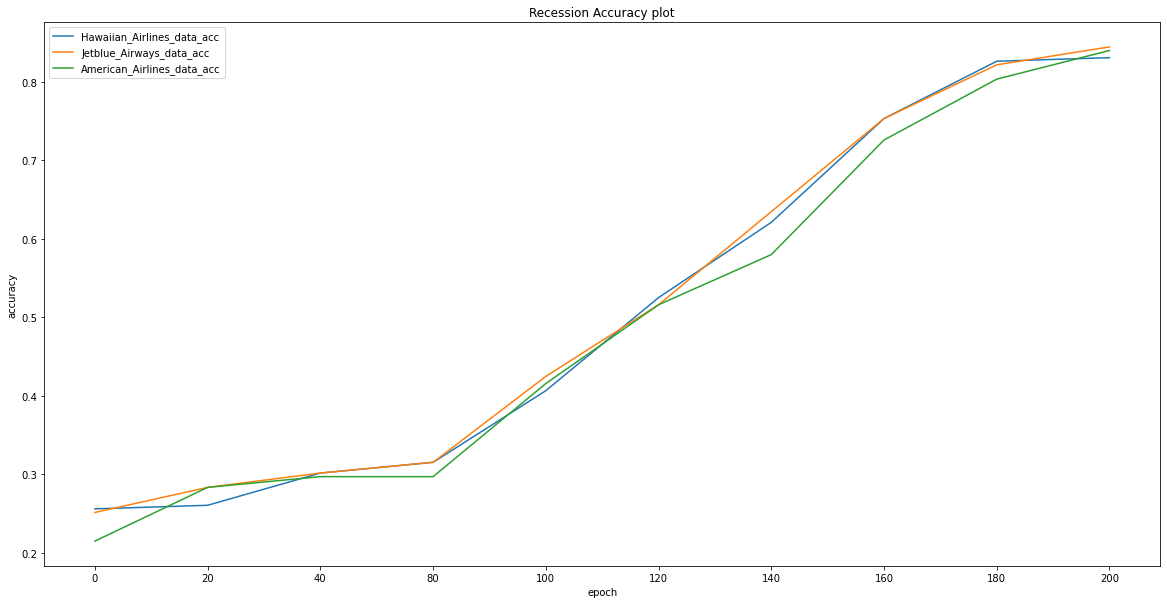

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Hawaiian_Airlines_data_acc)
plt.plot(Jetblue_Airways_data_acc)
plt.plot(American_Airlines_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Hawaiian_Airlines_data_acc','Jetblue_Airways_data_acc','American_Airlines_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'American_Airlines_data_correct_buys')

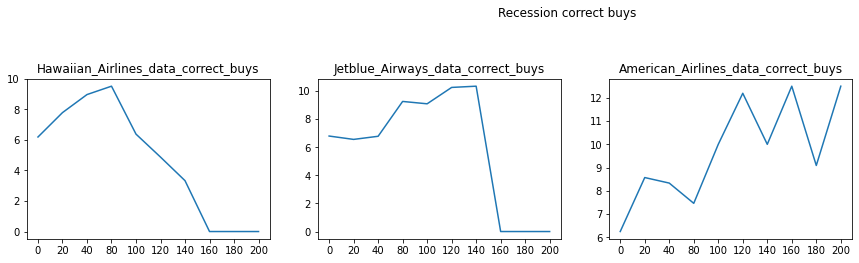

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_sells')

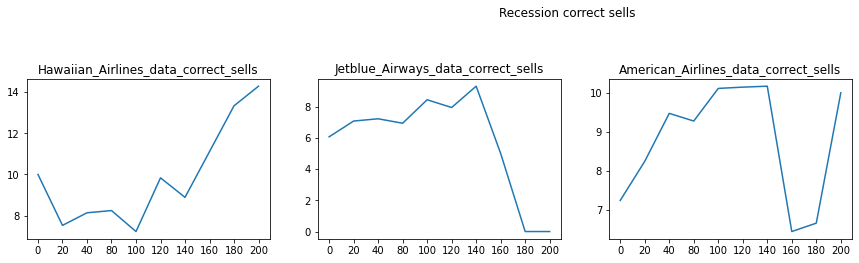

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_low_buys')

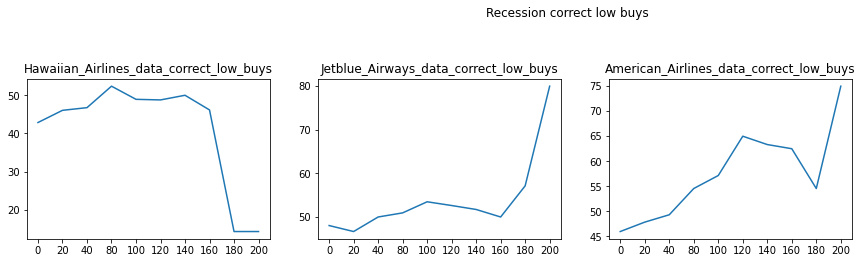

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_low_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_high_sells')

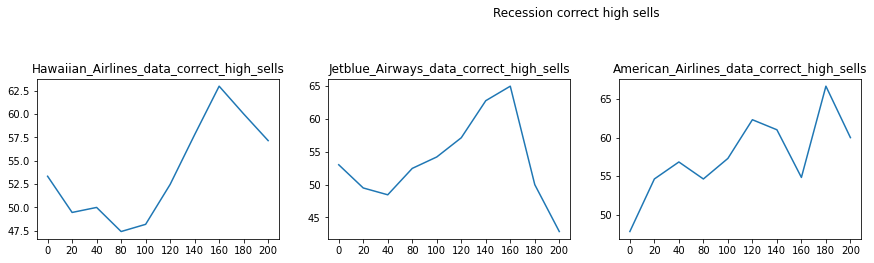

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_high_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_mid_holds')

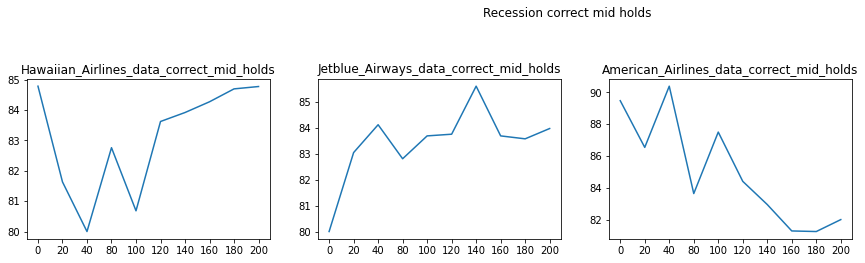

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_mid_holds")

Text(0.5, 1.0, 'American_Airlines_data_profit')

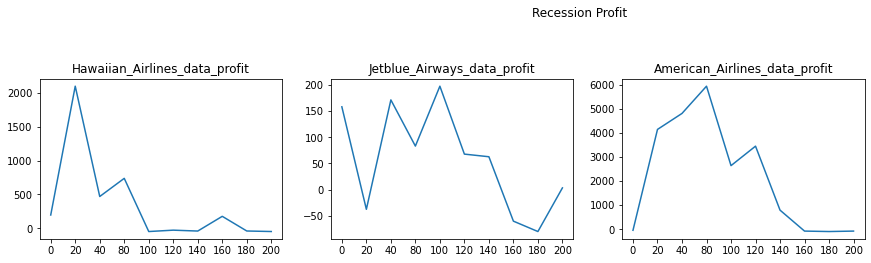

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_profit")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_profit")

## Train American Airlines Stock Data

In [71]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2005-10-17    22.270000  21.619546 -18.717939  12563700.0     2.0
2005-10-18    22.080000  21.690385 -24.210533  12099700.0     2.0
2005-10-19    21.490000  21.659557 -52.068980  10284200.0     2.0
2005-10-20    21.379999  21.616548 -57.446844   8818200.0     1.0
2005-10-21    21.020000  21.524771 -92.093018   8177300.0     2.0


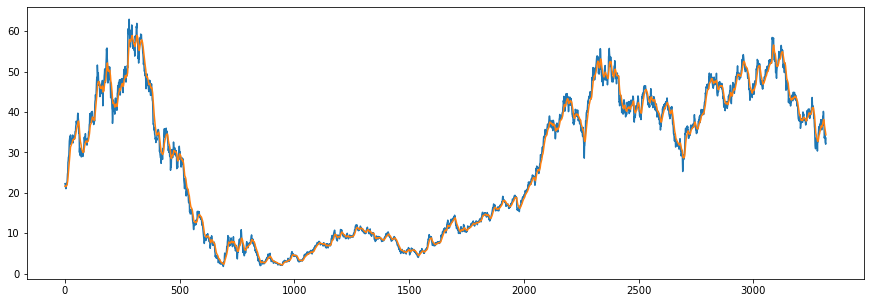

(3303, 64, 64, 1)

In [72]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/AAL_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

In [73]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(3303, 15, 1)

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [75]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(3303, 64, 64, 1)

In [76]:
from collections import Counter

Counter(y)

Counter({2.0: 3022, 0.0: 140, 1.0: 141})

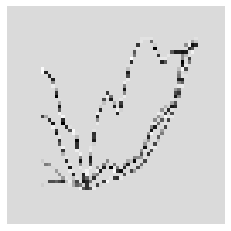

In [77]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [78]:
X = X/255

In [79]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [80]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [81]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [83]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['HA','JBLU','AAL']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'AmericanairModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'AmericanairModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.863095238095238, 1: 7.793510324483776, 2: 0.3643635360639912}



RUNNING EPOCHS 0 - 20



Epoch 1/20
21/21 [==============================] - 1s 56ms/step - loss: 0.2438 - accuracy: 0.4542 - mse: 1.7696 - weighted_accuracy: 0.3887 - weighted_mse: 1.8419 - val_loss: 0.2038 - val_accuracy: 0.0424 - val_mse: 0.8787 - val_weighted_accuracy: 0.0424 - val_weighted_mse: 0.8787
Epoch 2/20
21/21 [==============================] - 0s 10ms/step - loss: 0.2083 - accuracy: 0.2782 - mse: 1.1770 - weighted_accuracy: 0.3128 - weighted_mse: 1.1676 - val_loss: 0.1950 - val_accuracy: 0.4251 - val_mse: 0.8693 - val_weighted_accuracy: 0.4251 - val_weighted_mse: 0.8693
Epoch 3/20
21/21 [==============================] - 0s 10ms/step - loss: 0.2034 - accuracy: 0.4141 - mse: 1.1631 - weighted_accuracy: 0.3594 - weighted_mse: 1.2038 - val_loss: 0.1877 - val_accuracy: 0.9092 - val_mse: 0.8930 - val_weighted_accuracy: 0.9092 - val_weighted_mse: 0.8930
Epoch 4/20
21/21 [==============================] - 0s 

7/7 [==============================] - 0s 2ms/step - loss: 0.1979 - accuracy: 0.0959 - mse: 0.9850 - weighted_accuracy: 0.0959 - weighted_mse: 0.9850
Test loss: 0.19794140756130219
Test accuracy: 0.09589041024446487


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 3
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 97
actual holds but predicted sell: 93
actual predicted holds: 9
Percentage buys correct: 3.883495145631068%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 75.0%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 42.15686274509804%
Percentage high sells correct: 47.11538461538461%
Percentage mid holds correct: 66.66666666666667%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bo

Cash capital at the moment: $0.06808051851032815


Price increase from previously bought: 7.698110676698233%
Share price: $0.3302932560072145
Shares owned at the moment: 0
Cash capital at the moment: $347.5692022971307


Share price: $0.4696574793712551
Shares owned at the moment: 738
Cash capital at the moment: $0.00881266676043424


Price increase from previously bought: 24.645597708204736%
Share price: $0.5870172426175342
Shares owned at the moment: 0
Cash capital at the moment: $432.0361862246084


Share price: $0.753276013389679
Shares owned at the moment: 571
Cash capital at the moment: $0.7327509190765227


Price increase from previously bought: -6.424319643760934%
Share price: $0.7068215831645934
Shares owned at the moment: 0
Cash capital at the moment: $403.21798831509517


Share price: $0.6872617003476111
Shares owned at the moment: 585
Cash capital at the moment: $0.06426135130845978


Price increase from previously bought: -31.4951202250902%
Share price: $0.4721025230164277

7/7 [==============================] - 0s 2ms/step - loss: 0.1975 - accuracy: 0.1422 - mse: 0.9854 - weighted_accuracy: 0.1422 - weighted_mse: 0.9854
Test loss: 0.19753515720367432
Test accuracy: 0.14220184087753296


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 0
actual holds but predicted buy: 95
actual holds but predicted sell: 87
actual predicted holds: 21
Percentage buys correct: 5.769230769230769%
Percentage sells correct: 4.3478260869565215%
Percentage holds correct: 95.45454545454545%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 44.23076923076923%
Percentage high sells correct: 41.75824175824176%
Percentage mid holds correct: 90.9090909090909%


Capital: 100
Share price: $0.9408072327166555
Shares owned at the moment: 106
Cash capital at the moment: $0.00018802369761772297


Pri



Share price: $0.12805878719235386
Shares owned at the moment: 3327
Cash capital at the moment: $0.0852276912950174


Price increase from previously bought: -18.807229615230746%
Share price: $0.10426040685447534
Shares owned at the moment: 0
Cash capital at the moment: $346.0056967687211


Share price: $0.06739619846626203
Shares owned at the moment: 5119
Cash capital at the moment: $0.05580368506656441


Price increase from previously bought: 119.8688897016829%
Share price: $0.14859077727040249
Shares owned at the moment: 0
Cash capital at the moment: $758.600243012927


Share price: $0.03193188433278598
Shares owned at the moment: 23691
Cash capital at the moment: $0.021601037642199117


Price increase from previously bought: 52.189912580272456%
Share price: $0.04873074889514178
Shares owned at the moment: 0
Cash capital at the moment: $1151.3269526392405


Share price: $0.3693093813474916
Shares owned at the moment: 3108
Cash capital at the moment: $0.3569081288594589


Price incre

Epoch 11/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1967 - accuracy: 0.2782 - mse: 1.1589 - weighted_accuracy: 0.4120 - weighted_mse: 1.1410 - val_loss: 0.2008 - val_accuracy: 0.0605 - val_mse: 1.0434 - val_weighted_accuracy: 0.0605 - val_weighted_mse: 1.0434
Epoch 12/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1986 - accuracy: 0.2774 - mse: 1.2009 - weighted_accuracy: 0.3835 - weighted_mse: 1.1832 - val_loss: 0.2012 - val_accuracy: 0.0605 - val_mse: 1.0548 - val_weighted_accuracy: 0.0605 - val_weighted_mse: 1.0548
Epoch 13/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1953 - accuracy: 0.2619 - mse: 1.1674 - weighted_accuracy: 0.4204 - weighted_mse: 1.1652 - val_loss: 0.1940 - val_accuracy: 0.0620 - val_mse: 0.9825 - val_weighted_accuracy: 0.0620 - val_weighted_mse: 0.9825
Epoch 14/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1969 - accuracy: 0.2665 - mse: 1.1957 - weighted_accuracy: 0.4249 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1957 - accuracy: 0.0731 - mse: 0.9714 - weighted_accuracy: 0.0731 - weighted_mse: 0.9714
Test loss: 0.1957438737154007
Test accuracy: 0.07305935770273209


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 123
actual holds but predicted sell: 76
actual predicted holds: 0
Percentage buys correct: 6.015037593984962%
Percentage sells correct: 9.30232558139535%
Percentage holds correct: 0%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 44.696969696969695%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Price increase from previously bought: -81.0156260

7/7 [==============================] - 0s 2ms/step - loss: 0.1955 - accuracy: 0.0642 - mse: 0.9813 - weighted_accuracy: 0.0642 - weighted_mse: 0.9813
Test loss: 0.19547881186008453
Test accuracy: 0.06422018259763718


number of predictions: 218
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 4
actual sells but predicted hold: 0
actual holds but predicted buy: 118
actual holds but predicted sell: 82
actual predicted holds: 0
Percentage buys correct: 7.575757575757576%
Percentage sells correct: 4.651162790697675%
Percentage holds correct: 0%
actual buys: 10
actual sells: 8
actual holds: 200


Percentage low buys correct: 46.21212121212121%
Percentage high sells correct: 50.588235294117645%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.6432518474233075
Shares owned at the moment: 155
Cash capital at the moment: $0.021777549423148912


Price increase from previously bou


Share price: $0.8617006527771238
Shares owned at the moment: 123
Cash capital at the moment: $0.7227642908017771


Price increase from previously bought: -64.8318469407043%
Share price: $0.30387757604393356
Shares owned at the moment: 0
Cash capital at the moment: $37.99691955410874


Share price: $0.2651020199633887
Shares owned at the moment: 142
Cash capital at the moment: $0.24891038051183756


Price increase from previously bought: 7.914696944245292%
Share price: $0.28687077255051413
Shares owned at the moment: 0
Cash capital at the moment: $40.87253704600387


Share price: $0.09503398502919407
Shares owned at the moment: 428
Cash capital at the moment: $0.0861364531294484


Price increase from previously bought: 98.95186764765972%
Share price: $0.1895918358078968
Shares owned at the moment: 0
Cash capital at the moment: $81.00829258816339


Share price: $0.13721084990777738
Shares owned at the moment: 588
Cash capital at the moment: $0.1064428980894121


Price increase from prev

7/7 [==============================] - 0s 2ms/step - loss: 0.1966 - accuracy: 0.0776 - mse: 0.9826 - weighted_accuracy: 0.0776 - weighted_mse: 0.9826
Test loss: 0.19658702611923218
Test accuracy: 0.077625572681427


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 112
actual holds but predicted sell: 86
actual predicted holds: 0
Percentage buys correct: 6.504065040650406%
Percentage sells correct: 9.375%
Percentage holds correct: 0%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 45.90163934426229%
Percentage high sells correct: 47.916666666666664%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9185394706586716
Shares owned at the moment: 108
Cash capital at the moment: $0.5249309460778306


Price increase from previously bought: -72.21511603

Epoch 5/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1934 - accuracy: 0.2343 - mse: 1.1989 - weighted_accuracy: 0.4273 - weighted_mse: 1.1672 - val_loss: 0.1929 - val_accuracy: 0.0711 - val_mse: 1.0026 - val_weighted_accuracy: 0.0711 - val_weighted_mse: 1.0026
Epoch 6/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1951 - accuracy: 0.2430 - mse: 1.2095 - weighted_accuracy: 0.3824 - weighted_mse: 1.1907 - val_loss: 0.1946 - val_accuracy: 0.0696 - val_mse: 1.0371 - val_weighted_accuracy: 0.0696 - val_weighted_mse: 1.0371
Epoch 7/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1906 - accuracy: 0.2184 - mse: 1.2317 - weighted_accuracy: 0.4385 - weighted_mse: 1.2240 - val_loss: 0.1970 - val_accuracy: 0.0696 - val_mse: 1.0063 - val_weighted_accuracy: 0.0696 - val_weighted_mse: 1.0063
Epoch 8/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1893 - accuracy: 0.2226 - mse: 1.1886 - weighted_accuracy: 0.4681 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.1980 - accuracy: 0.0776 - mse: 1.0604 - weighted_accuracy: 0.0776 - weighted_mse: 1.0604
Test loss: 0.19798599183559418
Test accuracy: 0.077625572681427


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 129
actual holds but predicted sell: 70
actual predicted holds: 0
Percentage buys correct: 6.428571428571429%
Percentage sells correct: 10.126582278481013%
Percentage holds correct: 0%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 45.32374100719424%
Percentage high sells correct: 50.63291139240506%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Price increase from previously bought

7/7 [==============================] - 0s 2ms/step - loss: 0.2005 - accuracy: 0.0731 - mse: 1.0648 - weighted_accuracy: 0.0731 - weighted_mse: 1.0648
Test loss: 0.20046912133693695
Test accuracy: 0.07305935770273209


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 110
actual holds but predicted sell: 87
actual predicted holds: 0
Percentage buys correct: 7.258064516129032%
Percentage sells correct: 7.368421052631579%
Percentage holds correct: 0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.96747967479675%
Percentage high sells correct: 48.421052631578945%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


Price increase from previously boug

7/7 [==============================] - 0s 2ms/step - loss: 0.1995 - accuracy: 0.0776 - mse: 1.0803 - weighted_accuracy: 0.0776 - weighted_mse: 1.0803
Test loss: 0.19947344064712524
Test accuracy: 0.077625572681427


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 124
actual holds but predicted sell: 74
actual predicted holds: 0
Percentage buys correct: 5.925925925925926%
Percentage sells correct: 10.714285714285714%
Percentage holds correct: 0%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 49.25373134328358%
Percentage high sells correct: 55.95238095238095%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.9101400161265754
Shares owned at the moment: 109
Cash capital at the moment: $0.521923772369334


Price increase from previously bought: -

Epoch 6/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1750 - accuracy: 0.1718 - mse: 1.2675 - weighted_accuracy: 0.5541 - weighted_mse: 1.2429 - val_loss: 0.1946 - val_accuracy: 0.0802 - val_mse: 1.0733 - val_weighted_accuracy: 0.0802 - val_weighted_mse: 1.0733
Epoch 7/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1771 - accuracy: 0.1927 - mse: 1.3215 - weighted_accuracy: 0.5053 - weighted_mse: 1.2962 - val_loss: 0.1970 - val_accuracy: 0.0847 - val_mse: 1.0145 - val_weighted_accuracy: 0.0847 - val_weighted_mse: 1.0145
Epoch 8/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1746 - accuracy: 0.1787 - mse: 1.3209 - weighted_accuracy: 0.5257 - weighted_mse: 1.2819 - val_loss: 0.1999 - val_accuracy: 0.0832 - val_mse: 0.9468 - val_weighted_accuracy: 0.0832 - val_weighted_mse: 0.9468
Epoch 9/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1746 - accuracy: 0.1809 - mse: 1.2748 - weighted_accuracy: 0.5292 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.1963 - accuracy: 0.1279 - mse: 1.0860 - weighted_accuracy: 0.1279 - weighted_mse: 1.0860
Test loss: 0.19629862904548645
Test accuracy: 0.1278538852930069


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 105
actual holds but predicted sell: 81
actual predicted holds: 13
Percentage buys correct: 7.017543859649122%
Percentage sells correct: 7.865168539325842%
Percentage holds correct: 81.25%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 44.24778761061947%
Percentage high sells correct: 48.31460674157304%
Percentage mid holds correct: 75.0%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Price increase from previousl

7/7 [==============================] - 0s 2ms/step - loss: 0.1990 - accuracy: 0.1239 - mse: 1.1069 - weighted_accuracy: 0.1239 - weighted_mse: 1.1069
Test loss: 0.19899778068065643
Test accuracy: 0.12385321408510208


number of predictions: 218
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 1
actual holds but predicted buy: 106
actual holds but predicted sell: 81
actual predicted holds: 13
Percentage buys correct: 8.403361344537815%
Percentage sells correct: 4.705882352941177%
Percentage holds correct: 92.85714285714286%
actual buys: 10
actual sells: 8
actual holds: 200


Percentage low buys correct: 47.89915966386555%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 92.85714285714286%


Capital: 100
Share price: $0.6432518474233075
Shares owned at the moment: 155
Cash capital at the moment: $0.021777549423148912


Price increase 

Share price: $0.15421765340119703
Shares owned at the moment: 327
Cash capital at the moment: $0.04354033406031732


Price increase from previously bought: 33.15831526569946%
Share price: $0.20591835159138577
Shares owned at the moment: 0
Cash capital at the moment: $67.19366922677492


Share price: $0.08891159026724087
Shares owned at the moment: 753
Cash capital at the moment: $0.05912807999665404


Price increase from previously bought: 2.7778011488970744%
Share price: $0.09163267623115572
Shares owned at the moment: 0
Cash capital at the moment: $68.86878491775124


Share price: $0.15421765340119703
Shares owned at the moment: 445
Cash capital at the moment: $0.053205300868853556


Price increase from previously bought: 8.963697583630514%
Share price: $0.1685033709307016
Shares owned at the moment: 0
Cash capital at the moment: $74.83099936485462


Share price: $0.2991156269502276
Shares owned at the moment: 249
Cash capital at the moment: $0.14638882869377312


Price increase from

7/7 [==============================] - 0s 2ms/step - loss: 0.1987 - accuracy: 0.1553 - mse: 1.1092 - weighted_accuracy: 0.1553 - weighted_mse: 1.1092
Test loss: 0.19865964353084564
Test accuracy: 0.155251145362854


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 101
actual holds but predicted sell: 80
actual predicted holds: 17
Percentage buys correct: 6.363636363636363%
Percentage sells correct: 10.869565217391305%
Percentage holds correct: 100.0%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 48.62385321100918%
Percentage high sells correct: 53.26086956521739%
Percentage mid holds correct: 76.47058823529412%


Capital: 100
Share price: $0.9101400161265754
Shares owned at the moment: 109
Cash capital at the moment: $0.521923772369334


Price increase fro

Epoch 4/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1698 - accuracy: 0.1934 - mse: 1.3563 - weighted_accuracy: 0.5341 - weighted_mse: 1.3139 - val_loss: 0.2003 - val_accuracy: 0.1452 - val_mse: 1.1364 - val_weighted_accuracy: 0.1452 - val_weighted_mse: 1.1364
Epoch 5/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1690 - accuracy: 0.1874 - mse: 1.3480 - weighted_accuracy: 0.5429 - weighted_mse: 1.2673 - val_loss: 0.1980 - val_accuracy: 0.1604 - val_mse: 1.1594 - val_weighted_accuracy: 0.1604 - val_weighted_mse: 1.1594
Epoch 6/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1668 - accuracy: 0.1991 - mse: 1.3892 - weighted_accuracy: 0.5556 - weighted_mse: 1.3731 - val_loss: 0.2009 - val_accuracy: 0.1225 - val_mse: 0.9504 - val_weighted_accuracy: 0.1225 - val_weighted_mse: 0.9504
Epoch 7/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1673 - accuracy: 0.1934 - mse: 1.3415 - weighted_accuracy: 0.5565 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.1962 - accuracy: 0.2055 - mse: 1.2075 - weighted_accuracy: 0.2055 - weighted_mse: 1.2075
Test loss: 0.19623133540153503
Test accuracy: 0.2054794579744339


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 110
actual holds but predicted sell: 58
actual predicted holds: 31
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 9.23076923076923%
Percentage holds correct: 91.17647058823529%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 44.53781512605042%
Percentage high sells correct: 56.92307692307692%
Percentage mid holds correct: 88.23529411764706%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Price

7/7 [==============================] - 0s 2ms/step - loss: 0.2006 - accuracy: 0.1872 - mse: 1.2199 - weighted_accuracy: 0.1872 - weighted_mse: 1.2199
Test loss: 0.20061251521110535
Test accuracy: 0.18721461296081543


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 5
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 100
actual holds but predicted sell: 71
actual predicted holds: 26
Percentage buys correct: 7.079646017699115%
Percentage sells correct: 8.860759493670885%
Percentage holds correct: 96.29629629629629%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 46.42857142857143%
Percentage high sells correct: 55.69620253164557%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


Pri

7/7 [==============================] - 0s 2ms/step - loss: 0.2000 - accuracy: 0.1689 - mse: 1.2393 - weighted_accuracy: 0.1689 - weighted_mse: 1.2393
Test loss: 0.2000441998243332
Test accuracy: 0.16894976794719696


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 112
actual holds but predicted sell: 63
actual predicted holds: 23
Percentage buys correct: 5.785123966942149%
Percentage sells correct: 9.859154929577464%
Percentage holds correct: 85.18518518518519%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 48.333333333333336%
Percentage high sells correct: 59.15492957746479%
Percentage mid holds correct: 70.37037037037037%


Capital: 100
Share price: $0.9101400161265754
Shares owned at the moment: 109
Cash capital at the moment: $0.521923772369334


Price 

Epoch 6/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1553 - accuracy: 0.2574 - mse: 1.4628 - weighted_accuracy: 0.5797 - weighted_mse: 1.5162 - val_loss: 0.1960 - val_accuracy: 0.2224 - val_mse: 1.1876 - val_weighted_accuracy: 0.2224 - val_weighted_mse: 1.1876
Epoch 7/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1534 - accuracy: 0.2468 - mse: 1.4677 - weighted_accuracy: 0.6070 - weighted_mse: 1.4792 - val_loss: 0.1925 - val_accuracy: 0.2421 - val_mse: 1.1852 - val_weighted_accuracy: 0.2421 - val_weighted_mse: 1.1852
Epoch 8/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1540 - accuracy: 0.2551 - mse: 1.4188 - weighted_accuracy: 0.5818 - weighted_mse: 1.4165 - val_loss: 0.1973 - val_accuracy: 0.2360 - val_mse: 1.2948 - val_weighted_accuracy: 0.2360 - val_weighted_mse: 1.2948
Epoch 9/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1536 - accuracy: 0.2464 - mse: 1.4983 - weighted_accuracy: 0.6040 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.1971 - accuracy: 0.2192 - mse: 1.3235 - weighted_accuracy: 0.2192 - weighted_mse: 1.3235
Test loss: 0.1971130222082138
Test accuracy: 0.21917808055877686


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 105
actual holds but predicted sell: 60
actual predicted holds: 34
Percentage buys correct: 6.956521739130435%
Percentage sells correct: 8.955223880597014%
Percentage holds correct: 91.89189189189189%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 44.73684210526316%
Percentage high sells correct: 53.73134328358209%
Percentage mid holds correct: 83.78378378378379%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Pric

7/7 [==============================] - 0s 2ms/step - loss: 0.2017 - accuracy: 0.2009 - mse: 1.3450 - weighted_accuracy: 0.2009 - weighted_mse: 1.3450
Test loss: 0.20173409581184387
Test accuracy: 0.2009132355451584


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 5
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 96
actual holds but predicted sell: 72
actual predicted holds: 29
Percentage buys correct: 7.339449541284404%
Percentage sells correct: 8.75%
Percentage holds correct: 96.66666666666667%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 43.51851851851852%
Percentage high sells correct: 55.0%
Percentage mid holds correct: 90.0%


Capital: 100
Share price: $0.9385714772282836
Shares owned at the moment: 106
Cash capital at the moment: $0.23782982818988785


Price increase from previously bought: 7.315

7/7 [==============================] - 0s 2ms/step - loss: 0.2009 - accuracy: 0.2146 - mse: 1.3554 - weighted_accuracy: 0.2146 - weighted_mse: 1.3554
Test loss: 0.20085854828357697
Test accuracy: 0.21461187303066254


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 106
actual holds but predicted sell: 59
actual predicted holds: 33
Percentage buys correct: 6.086956521739131%
Percentage sells correct: 10.447761194029852%
Percentage holds correct: 89.1891891891892%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 48.24561403508772%
Percentage high sells correct: 59.701492537313435%
Percentage mid holds correct: 75.67567567567568%


Capital: 100
Share price: $0.9101400161265754
Shares owned at the moment: 109
Cash capital at the moment: $0.521923772369334


Price

Epoch 7/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1442 - accuracy: 0.2896 - mse: 1.5419 - weighted_accuracy: 0.6450 - weighted_mse: 1.6113 - val_loss: 0.1895 - val_accuracy: 0.3162 - val_mse: 1.4581 - val_weighted_accuracy: 0.3162 - val_weighted_mse: 1.4581
Epoch 8/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1425 - accuracy: 0.2824 - mse: 1.6748 - weighted_accuracy: 0.6397 - weighted_mse: 1.6974 - val_loss: 0.1849 - val_accuracy: 0.3283 - val_mse: 1.4845 - val_weighted_accuracy: 0.3283 - val_weighted_mse: 1.4845
Epoch 9/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1442 - accuracy: 0.2971 - mse: 1.5954 - weighted_accuracy: 0.6422 - weighted_mse: 1.6189 - val_loss: 0.1858 - val_accuracy: 0.3510 - val_mse: 1.3889 - val_weighted_accuracy: 0.3510 - val_weighted_mse: 1.3889
Epoch 10/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1397 - accuracy: 0.3266 - mse: 1.6448 - weighted_accuracy: 0.6754 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1791 - accuracy: 0.4201 - mse: 1.4066 - weighted_accuracy: 0.4201 - weighted_mse: 1.4066
Test loss: 0.17907822132110596
Test accuracy: 0.42009133100509644


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 75
actual holds but predicted sell: 46
actual predicted holds: 78
Percentage buys correct: 9.63855421686747%
Percentage sells correct: 11.320754716981131%
Percentage holds correct: 93.97590361445783%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 46.34146341463415%
Percentage high sells correct: 50.943396226415096%
Percentage mid holds correct: 86.74698795180723%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Pri

7/7 [==============================] - 0s 2ms/step - loss: 0.1848 - accuracy: 0.3425 - mse: 1.4336 - weighted_accuracy: 0.3425 - weighted_mse: 1.4336
Test loss: 0.18484841287136078
Test accuracy: 0.34246575832366943


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 5
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 74
actual holds but predicted sell: 61
actual predicted holds: 62
Percentage buys correct: 9.195402298850574%
Percentage sells correct: 7.575757575757576%
Percentage holds correct: 93.93939393939394%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 41.86046511627907%
Percentage high sells correct: 59.09090909090909%
Percentage mid holds correct: 89.39393939393939%


Capital: 100
Share price: $0.8617006527771238
Shares owned at the moment: 115
Cash capital at the moment: $0.6319120991900036


Price

7/7 [==============================] - 0s 2ms/step - loss: 0.1842 - accuracy: 0.3699 - mse: 1.4371 - weighted_accuracy: 0.3699 - weighted_mse: 1.4371
Test loss: 0.18421246111392975
Test accuracy: 0.36986300349235535


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 74
actual holds but predicted sell: 53
actual predicted holds: 71
Percentage buys correct: 7.317073170731708%
Percentage sells correct: 6.896551724137931%
Percentage holds correct: 89.87341772151899%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 48.148148148148145%
Percentage high sells correct: 60.3448275862069%
Percentage mid holds correct: 78.48101265822785%


Capital: 100
Share price: $0.9185394706586716
Shares owned at the moment: 108
Cash capital at the moment: $0.5249309460778306


Price 

Epoch 9/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1291 - accuracy: 0.4012 - mse: 1.8604 - weighted_accuracy: 0.7084 - weighted_mse: 2.0678 - val_loss: 0.1766 - val_accuracy: 0.4523 - val_mse: 1.5784 - val_weighted_accuracy: 0.4523 - val_weighted_mse: 1.5784
Epoch 10/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1321 - accuracy: 0.3929 - mse: 1.8079 - weighted_accuracy: 0.6770 - weighted_mse: 2.0027 - val_loss: 0.1658 - val_accuracy: 0.5219 - val_mse: 1.4775 - val_weighted_accuracy: 0.5219 - val_weighted_mse: 1.4775
Epoch 11/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1276 - accuracy: 0.4073 - mse: 1.8736 - weighted_accuracy: 0.7076 - weighted_mse: 2.1305 - val_loss: 0.1797 - val_accuracy: 0.4418 - val_mse: 1.5450 - val_weighted_accuracy: 0.4418 - val_weighted_mse: 1.5450
Epoch 12/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1310 - accuracy: 0.4277 - mse: 1.8428 - weighted_accuracy: 0.6953 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.1692 - accuracy: 0.5023 - mse: 1.6253 - weighted_accuracy: 0.5023 - weighted_mse: 1.6253
Test loss: 0.16920068860054016
Test accuracy: 0.5022830963134766


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 59
actual holds but predicted sell: 41
actual predicted holds: 99
Percentage buys correct: 9.23076923076923%
Percentage sells correct: 10.638297872340425%
Percentage holds correct: 92.5233644859813%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 42.1875%
Percentage high sells correct: 46.808510638297875%
Percentage mid holds correct: 84.11214953271028%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Price increase 

7/7 [==============================] - 0s 2ms/step - loss: 0.1764 - accuracy: 0.4977 - mse: 1.6490 - weighted_accuracy: 0.4977 - weighted_mse: 1.6490
Test loss: 0.1763879954814911
Test accuracy: 0.49771690368652344


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 4
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 54
actual holds but predicted sell: 46
actual predicted holds: 97
Percentage buys correct: 10.76923076923077%
Percentage sells correct: 9.803921568627452%
Percentage holds correct: 94.1747572815534%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 42.1875%
Percentage high sells correct: 60.78431372549019%
Percentage mid holds correct: 86.40776699029126%


Capital: 100
Share price: $0.8617006527771238
Shares owned at the moment: 115
Cash capital at the moment: $0.6319120991900036


Price increase fr

7/7 [==============================] - 0s 2ms/step - loss: 0.1753 - accuracy: 0.5023 - mse: 1.6599 - weighted_accuracy: 0.5023 - weighted_mse: 1.6599
Test loss: 0.1752680242061615
Test accuracy: 0.5022830963134766


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 58
actual holds but predicted sell: 40
actual predicted holds: 100
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 91.74311926605505%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 49.23076923076923%
Percentage high sells correct: 61.36363636363637%
Percentage mid holds correct: 79.81651376146789%


Capital: 100
Share price: $0.9185394706586716
Shares owned at the moment: 108
Cash capital at the moment: $0.5249309460778306


Price i

Epoch 12/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1225 - accuracy: 0.4902 - mse: 1.9360 - weighted_accuracy: 0.7463 - weighted_mse: 2.3338 - val_loss: 0.1685 - val_accuracy: 0.5219 - val_mse: 1.4678 - val_weighted_accuracy: 0.5219 - val_weighted_mse: 1.4678
Epoch 13/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1232 - accuracy: 0.4989 - mse: 1.8264 - weighted_accuracy: 0.7269 - weighted_mse: 2.1933 - val_loss: 0.1717 - val_accuracy: 0.5280 - val_mse: 1.7559 - val_weighted_accuracy: 0.5280 - val_weighted_mse: 1.7559
Epoch 14/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1226 - accuracy: 0.4951 - mse: 1.9619 - weighted_accuracy: 0.7199 - weighted_mse: 2.3755 - val_loss: 0.1670 - val_accuracy: 0.5582 - val_mse: 1.7296 - val_weighted_accuracy: 0.5582 - val_weighted_mse: 1.7296
Epoch 15/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1162 - accuracy: 0.5208 - mse: 2.1089 - weighted_accuracy: 0.7433 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1552 - accuracy: 0.6210 - mse: 1.8096 - weighted_accuracy: 0.6210 - weighted_mse: 1.8096
Test loss: 0.15521326661109924
Test accuracy: 0.621004581451416


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 39
actual holds but predicted sell: 33
actual predicted holds: 127
Percentage buys correct: 11.363636363636363%
Percentage sells correct: 10.81081081081081%
Percentage holds correct: 92.02898550724638%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 45.45454545454545%
Percentage high sells correct: 48.648648648648646%
Percentage mid holds correct: 83.94160583941606%


Capital: 100
Share price: $0.9831575829695464
Shares owned at the moment: 101
Cash capital at the moment: $0.42801210140602564


Pri

7/7 [==============================] - 0s 2ms/step - loss: 0.1644 - accuracy: 0.6073 - mse: 1.8301 - weighted_accuracy: 0.6073 - weighted_mse: 1.8301
Test loss: 0.1643780618906021
Test accuracy: 0.6073059439659119


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 4
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 34
actual holds but predicted sell: 36
actual predicted holds: 127
Percentage buys correct: 5.0%
Percentage sells correct: 10.0%
Percentage holds correct: 91.36690647482014%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 40.0%
Percentage high sells correct: 57.5%
Percentage mid holds correct: 84.78260869565217%


Capital: 100
Share price: $0.8617006527771238
Shares owned at the moment: 115
Cash capital at the moment: $0.6319120991900036


Price increase from previously bought: -76.09006671903798%


7/7 [==============================] - 0s 2ms/step - loss: 0.1626 - accuracy: 0.5753 - mse: 1.8444 - weighted_accuracy: 0.5753 - weighted_mse: 1.8444
Test loss: 0.16264225542545319
Test accuracy: 0.5753424763679504


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 46
actual holds but predicted sell: 35
actual predicted holds: 117
Percentage buys correct: 9.433962264150944%
Percentage sells correct: 10.256410256410257%
Percentage holds correct: 92.1259842519685%
actual buys: 9
actual sells: 12
actual holds: 198


Percentage low buys correct: 53.84615384615385%
Percentage high sells correct: 58.97435897435897%
Percentage mid holds correct: 81.10236220472441%


Capital: 100
Share price: $0.6292253805719137
Shares owned at the moment: 158
Cash capital at the moment: $0.30899144177914195


Price

Epoch 12/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1160 - accuracy: 0.5734 - mse: 2.1899 - weighted_accuracy: 0.7512 - weighted_mse: 2.6207 - val_loss: 0.1526 - val_accuracy: 0.6339 - val_mse: 1.7825 - val_weighted_accuracy: 0.6339 - val_weighted_mse: 1.7825
Epoch 13/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1105 - accuracy: 0.5821 - mse: 2.1614 - weighted_accuracy: 0.7713 - weighted_mse: 2.8599 - val_loss: 0.1522 - val_accuracy: 0.6263 - val_mse: 1.7277 - val_weighted_accuracy: 0.6263 - val_weighted_mse: 1.7277
Epoch 14/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1110 - accuracy: 0.6022 - mse: 2.0472 - weighted_accuracy: 0.7843 - weighted_mse: 2.6797 - val_loss: 0.1617 - val_accuracy: 0.5764 - val_mse: 1.8179 - val_weighted_accuracy: 0.5764 - val_weighted_mse: 1.8179
Epoch 15/20
21/21 [==============================] - 0s 9ms/step - loss: 0.1121 - accuracy: 0.5848 - mse: 2.1981 - weighted_accuracy: 0.7582 - weighted

Cash capital at the moment: $55.55039866593116


Share price: $0.3189311712930729
Shares owned at the moment: 173
Cash capital at the moment: $0.22357452748686768


Price increase from previously bought: -21.333719362933646%
Share price: $0.2515812412966749
Shares owned at the moment: 0
Cash capital at the moment: $43.627439496264735


Share price: $0.21448996740705284
Shares owned at the moment: 202
Cash capital at the moment: $0.18131690314544358


Price increase from previously bought: 7.4407817803354925%
Share price: $0.23108343449153634
Shares owned at the moment: 0
Cash capital at the moment: $46.731803822575735


Share price: $0.220346476988035
Shares owned at the moment: 211
Cash capital at the moment: $0.1108411348280427


Price increase from previously bought: 10.76982667067421%
Share price: $0.24474862351382853
Shares owned at the moment: 0
Cash capital at the moment: $51.61078530745196


Share price: $0.23401171255372788
Shares owned at the moment: 219
Cash capital at the m

7/7 [==============================] - 0s 2ms/step - loss: 0.1293 - accuracy: 0.7385 - mse: 1.8551 - weighted_accuracy: 0.7385 - weighted_mse: 1.8551
Test loss: 0.129273921251297
Test accuracy: 0.7385321259498596


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 17
actual holds but predicted sell: 30
actual predicted holds: 156
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 93.97590361445783%
actual buys: 8
actual sells: 7
actual holds: 203


Percentage low buys correct: 63.1578947368421%
Percentage high sells correct: 56.25%
Percentage mid holds correct: 86.144578313253%


Capital: 100
Share price: $0.9177430816973706
Shares owned at the moment: 108
Cash capital at the moment: $0.6111774814198441


Price increase from pre

In [84]:
Hawaiian_Airlines_data_acc = []
Jetblue_Airways_data_acc = []
American_Airlines_data_acc = []

Hawaiian_Airlines_data_correct_buys = []
Jetblue_Airways_data_correct_buys = []
American_Airlines_data_correct_buys = []

Hawaiian_Airlines_data_correct_sells = []
Jetblue_Airways_data_correct_sells = []
American_Airlines_data_correct_sells = []

Hawaiian_Airlines_data_correct_holds = []
Jetblue_Airways_data_correct_holds = []
American_Airlines_data_correct_holds = []

Hawaiian_Airlines_data_correct_low_buys = []
Jetblue_Airways_data_correct_low_buys = []
American_Airlines_data_correct_low_buys = []

Hawaiian_Airlines_data_correct_high_sells = []
Jetblue_Airways_data_correct_high_sells = []
American_Airlines_data_correct_high_sells = []

Hawaiian_Airlines_data_correct_mid_holds = []
Jetblue_Airways_data_correct_mid_holds = []
American_Airlines_data_correct_mid_holds = []

Hawaiian_Airlines_data_profit = []
Jetblue_Airways_data_profit = []
American_Airlines_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Hawaiian_Airlines_data_acc.append(acc[0])
    Jetblue_Airways_data_acc.append(acc[1])
    American_Airlines_data_acc.append(acc[2])
    
    Hawaiian_Airlines_data_correct_buys.append(correct_buys[0])
    Jetblue_Airways_data_correct_buys.append(correct_buys[1]) 
    American_Airlines_data_correct_buys.append(correct_buys[2]) 

    Hawaiian_Airlines_data_correct_sells.append(correct_sells[0]) 
    Jetblue_Airways_data_correct_sells.append(correct_sells[1]) 
    American_Airlines_data_correct_sells.append(correct_sells[2]) 

    Hawaiian_Airlines_data_correct_holds.append(correct_holds[0]) 
    Jetblue_Airways_data_correct_holds.append(correct_holds[1])  
    American_Airlines_data_correct_holds.append(correct_holds[2])  

    Hawaiian_Airlines_data_correct_low_buys.append(correct_low_buys[0])  
    Jetblue_Airways_data_correct_low_buys.append(correct_low_buys[1])  
    American_Airlines_data_correct_low_buys.append(correct_low_buys[2])  

    Hawaiian_Airlines_data_correct_high_sells.append(correct_high_sells[0]) 
    Jetblue_Airways_data_correct_high_sells.append(correct_high_sells[1]) 
    American_Airlines_data_correct_high_sells.append(correct_high_sells[2]) 

    Hawaiian_Airlines_data_correct_mid_holds.append(correct_mid_holds[0])  
    Jetblue_Airways_data_correct_mid_holds.append(correct_mid_holds[1])  
    American_Airlines_data_correct_mid_holds.append(correct_mid_holds[2])   

    Hawaiian_Airlines_data_profit.append(profit[0]) 
    Jetblue_Airways_data_profit.append(profit[1]) 
    American_Airlines_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


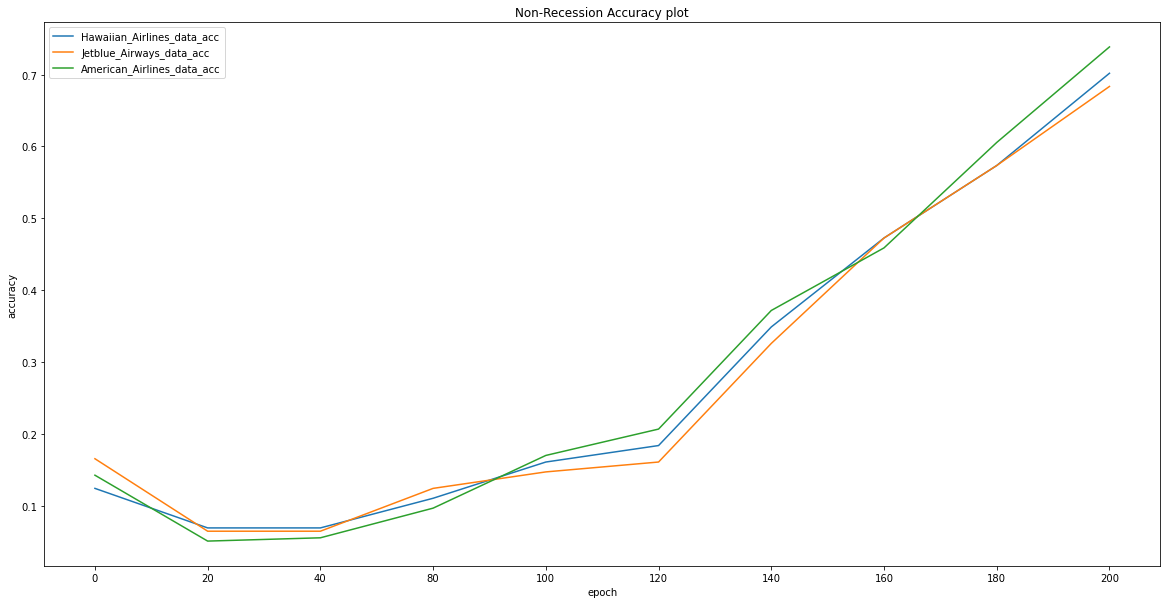

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Hawaiian_Airlines_data_acc)
plt.plot(Jetblue_Airways_data_acc)
plt.plot(American_Airlines_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Hawaiian_Airlines_data_acc','Jetblue_Airways_data_acc','American_Airlines_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'American_Airlines_data_correct_buys')

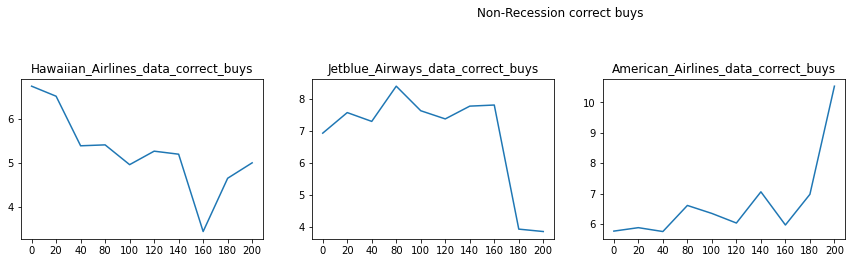

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_sells')

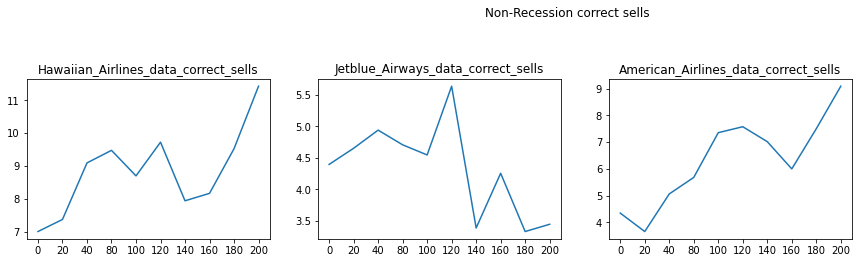

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_holds')

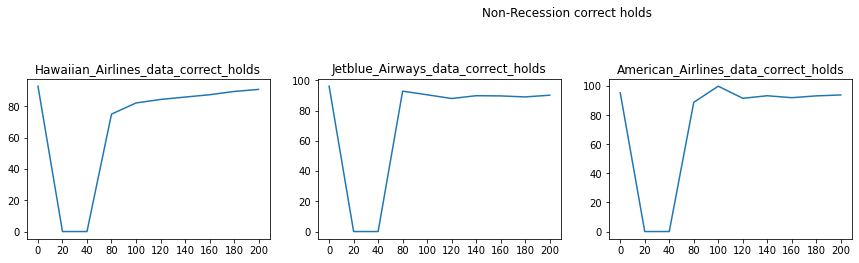

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_holds")

Text(0.5, 1.0, 'American_Airlines_data_correct_low_buys')

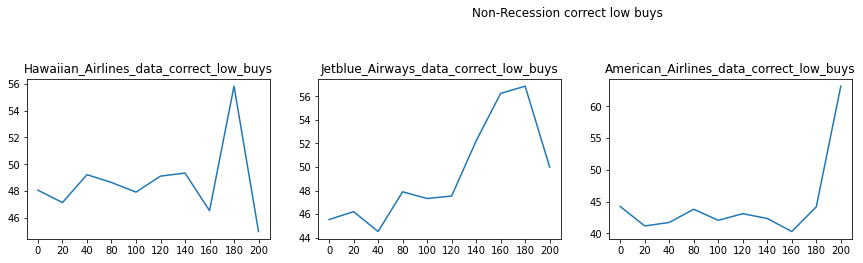

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_low_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_high_sells')

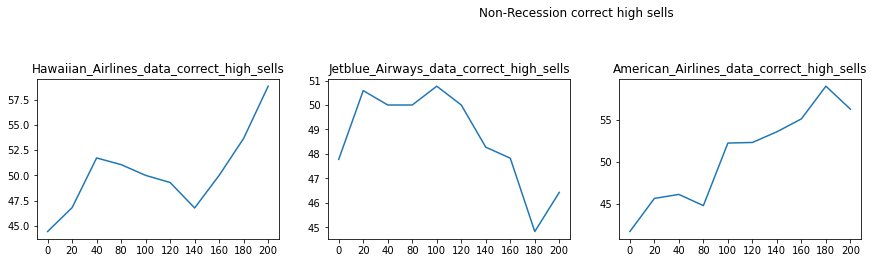

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_high_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_mid_holds')

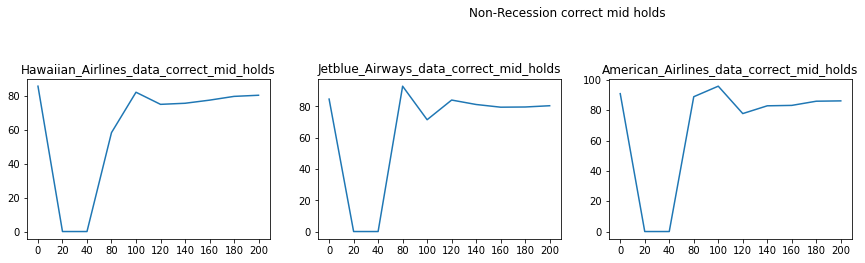

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_mid_holds")

Text(0.5, 1.0, 'American_Airlines_data_profit')

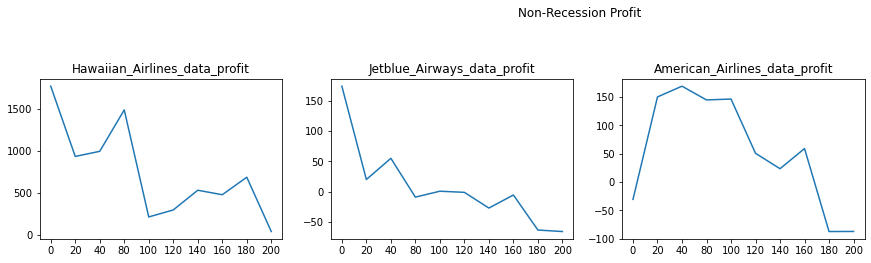

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_profit")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_profit")

In [93]:
Hawaiian_Airlines_data_acc = []
Jetblue_Airways_data_acc = []
American_Airlines_data_acc = []

Hawaiian_Airlines_data_correct_buys = []
Jetblue_Airways_data_correct_buys = []
American_Airlines_data_correct_buys = []

Hawaiian_Airlines_data_correct_sells = []
Jetblue_Airways_data_correct_sells = []
American_Airlines_data_correct_sells = []

Hawaiian_Airlines_data_correct_holds = []
Jetblue_Airways_data_correct_holds = []
American_Airlines_data_correct_holds = []

Hawaiian_Airlines_data_correct_low_buys = []
Jetblue_Airways_data_correct_low_buys = []
American_Airlines_data_correct_low_buys = []

Hawaiian_Airlines_data_correct_high_sells = []
Jetblue_Airways_data_correct_high_sells = []
American_Airlines_data_correct_high_sells = []

Hawaiian_Airlines_data_correct_mid_holds = []
Jetblue_Airways_data_correct_mid_holds = []
American_Airlines_data_correct_mid_holds = []

Hawaiian_Airlines_data_profit = []
Jetblue_Airways_data_profit = []
American_Airlines_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Hawaiian_Airlines_data_acc.append(acc[0])
    Jetblue_Airways_data_acc.append(acc[1])
    American_Airlines_data_acc.append(acc[2])
    
    Hawaiian_Airlines_data_correct_buys.append(correct_buys[0])
    Jetblue_Airways_data_correct_buys.append(correct_buys[1]) 
    American_Airlines_data_correct_buys.append(correct_buys[2]) 

    Hawaiian_Airlines_data_correct_sells.append(correct_sells[0]) 
    Jetblue_Airways_data_correct_sells.append(correct_sells[1]) 
    American_Airlines_data_correct_sells.append(correct_sells[2]) 

    Hawaiian_Airlines_data_correct_holds.append(correct_holds[0]) 
    Jetblue_Airways_data_correct_holds.append(correct_holds[1])  
    American_Airlines_data_correct_holds.append(correct_holds[2])  

    Hawaiian_Airlines_data_correct_low_buys.append(correct_low_buys[0])  
    Jetblue_Airways_data_correct_low_buys.append(correct_low_buys[1])  
    American_Airlines_data_correct_low_buys.append(correct_low_buys[2])  

    Hawaiian_Airlines_data_correct_high_sells.append(correct_high_sells[0]) 
    Jetblue_Airways_data_correct_high_sells.append(correct_high_sells[1]) 
    American_Airlines_data_correct_high_sells.append(correct_high_sells[2]) 

    Hawaiian_Airlines_data_correct_mid_holds.append(correct_mid_holds[0])  
    Jetblue_Airways_data_correct_mid_holds.append(correct_mid_holds[1])  
    American_Airlines_data_correct_mid_holds.append(correct_mid_holds[2])   

    Hawaiian_Airlines_data_profit.append(profit[0]) 
    Jetblue_Airways_data_profit.append(profit[1]) 
    American_Airlines_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


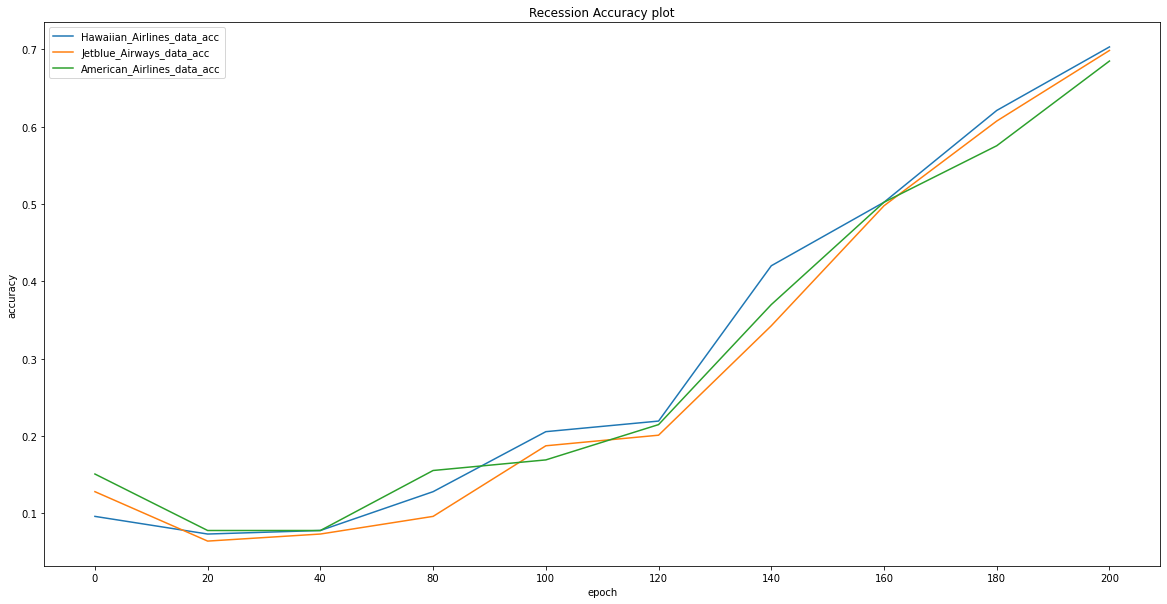

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Hawaiian_Airlines_data_acc)
plt.plot(Jetblue_Airways_data_acc)
plt.plot(American_Airlines_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Hawaiian_Airlines_data_acc','Jetblue_Airways_data_acc','American_Airlines_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'American_Airlines_data_correct_buys')

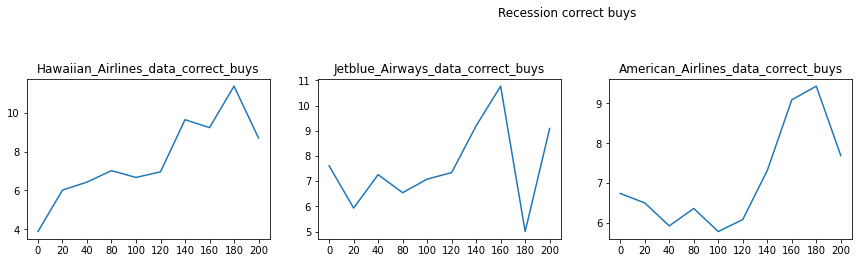

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_sells')

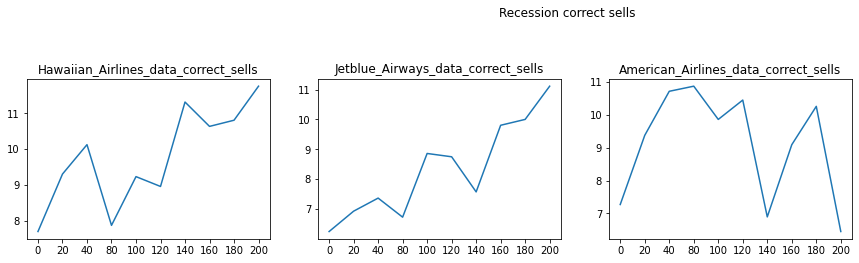

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_holds')

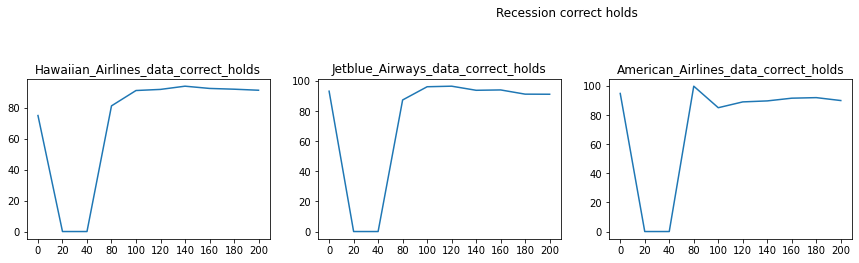

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_holds")

Text(0.5, 1.0, 'American_Airlines_data_correct_low_buys')

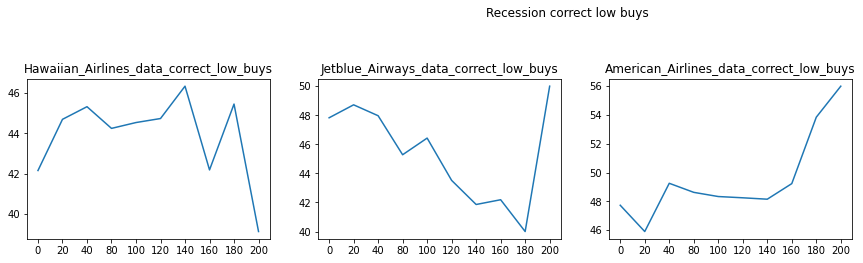

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_low_buys")

Text(0.5, 1.0, 'American_Airlines_data_correct_high_sells')

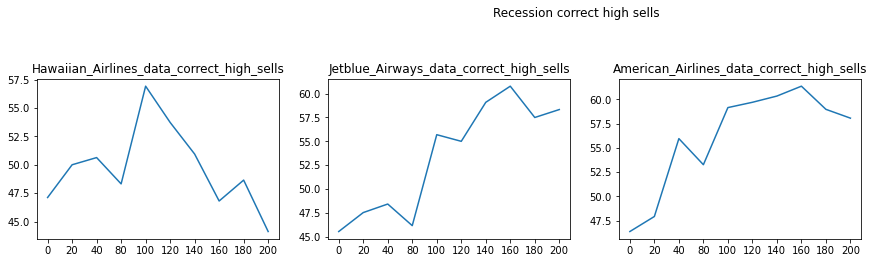

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_high_sells")

Text(0.5, 1.0, 'American_Airlines_data_correct_mid_holds')

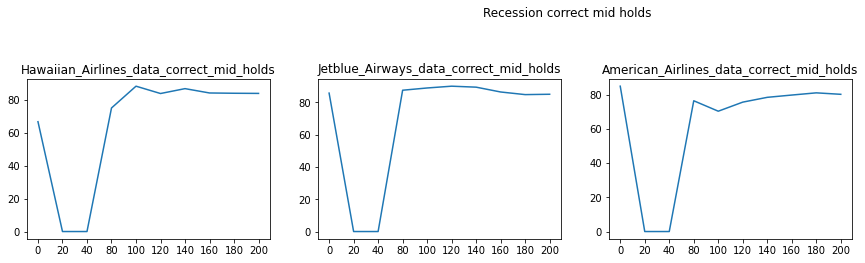

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_correct_mid_holds")

Text(0.5, 1.0, 'American_Airlines_data_profit')

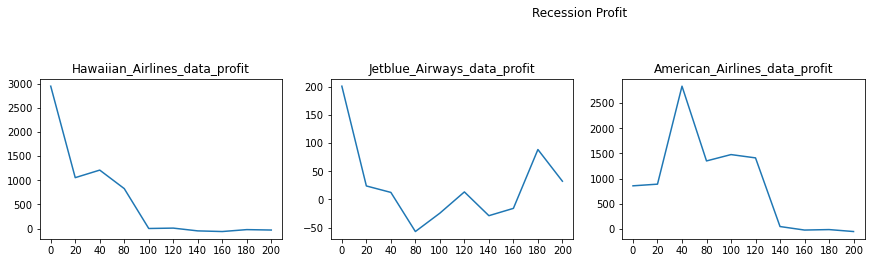

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Hawaiian_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Hawaiian_Airlines_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Jetblue_Airways_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Jetblue_Airways_data_profit")

plt.subplot(3, 4, 3)
plt.plot(American_Airlines_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Airlines_data_profit")